## Localizing Cancer

The following convolutional network design was implemented to localize cancerous nodules on a 2d slice of a ct scan. The network is in the function network implemented below, and was inspired by [Data Science Bowl 2017 contest](https://www.kaggle.com/c/data-science-bowl-2017#description) getting started tutorial. Code to run this network also came from that source.

In [9]:
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Convolution2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from __future__ import print_function
import matplotlib.pyplot as plt

In [2]:
working_path = "../outs/"

K.set_image_dim_ordering('th')  # Theano dimension ordering in this code

img_rows = 512
img_cols = 512

smooth = 1.

In [3]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [4]:
def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [5]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [6]:
def network():
    inputs = Input((1,img_rows, img_cols))
    conv1 = Conv2D(8, (4, 4), activation="sigmoid", padding="same")(inputs)
    conv1 = Conv2D(8, (4, 4), activation="sigmoid", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(16, (4, 4), activation="sigmoid", padding="same")(pool1)
    conv2 = Conv2D(16, (4, 4), activation="sigmoid", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(32, (4, 4), activation="sigmoid", padding="same")(pool2)
    conv3 = Conv2D(32, (4, 4), activation="sigmoid", padding="same")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, (4, 4), activation="sigmoid", padding="same")(pool3)
    conv4 = Conv2D(64, (4, 4), activation="sigmoid", padding="same")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(128, (4, 4), activation="sigmoid", padding="same")(pool4)
    conv5 = Conv2D(128, (4, 4), activation="sigmoid", padding="same")(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Conv2D(64, (4, 4), activation="sigmoid", padding="same")(up6)
    conv6 = Conv2D(64, (4, 4), activation="sigmoid", padding="same")(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Conv2D(32, (4, 4), activation="sigmoid", padding="same")(up7)
    conv7 = Conv2D(32, (4, 4), activation="sigmoid", padding="same")(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Conv2D(16, (4, 4), activation="sigmoid", padding="same")(up8)
    conv8 = Conv2D(16, (4, 4), activation="sigmoid", padding="same")(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Conv2D(8, (4, 4), activation="sigmoid", padding="same")(up9)
    conv9 = Conv2D(8, (4, 4), activation="sigmoid", padding="same")(conv9)
    
    conv10 = Conv2D(1, (1, 1), activation="sigmoid", padding="same")(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1.0e-3), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [7]:
print('-'*30)
print('Loading and preprocessing train data...')
print('-'*30)

imgs_train = np.load(working_path+"trainImages.npy").astype(np.float32)
imgs_mask_train = np.load(working_path+"trainMasks.npy").astype(np.float32)

imgs_test = np.load(working_path+"testImages.npy").astype(np.float32)
imgs_mask_test_true = np.load(working_path+"testMasks.npy").astype(np.float32)

'''mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean  # images should already be standardized, but just in case
imgs_train /= std'''

print('-'*30)
print('Creating and compiling model...')
print('-'*30)
model = network()
# Saving weights to unet.hdf5 at checkpoints
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', save_best_only=True)

# Set argument for call to train_and_predict to true at end of script
use_existing = False

if use_existing:
    model.load_weights('./unet.hdf5')

print('-'*30)
print('Fitting model...')
print('-'*30)

#model.set_weights([np.array([[[[100]]]], dtype=np.float32), np.array([-80], dtype=np.float32)])
model.fit(imgs_train, imgs_mask_train, batch_size=4, epochs=10, verbose=1, shuffle=True,
          callbacks=[model_checkpoint])

# loading best weights from training session
print('-'*30)
print('Loading saved weights...')
print('-'*30)

model.load_weights('./unet.hdf5')

print('-'*30)
print('Predicting masks on test data...')
print('-'*30)

num_test = len(imgs_test)
imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)

for i in range(num_test):
    imgs_mask_test[i] = model.predict([imgs_test[i:i+1]], verbose=0)[0]

np.save('masksTestPredicted.npy', imgs_mask_test)

mean = 0.0
for i in range(num_test):
    mean+=dice_coef_np(imgs_mask_test_true[i,0], imgs_mask_test[i,0])

mean/=num_test

print("Mean Dice Coeff : ",mean)

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------


C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\lucas\Anaconda3\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:34:

------------------------------
Fitting model...
------------------------------
Epoch 1/10
743/743 [==============================] - 74s 100ms/step - loss: -0.0150 - dice_coef: 0.0150
Epoch 2/10
743/743 [==============================] - 68s 92ms/step - loss: -0.0283 - dice_coef: 0.0283
Epoch 3/10
743/743 [==============================] - 70s 94ms/step - loss: -0.0315 - dice_coef: 0.0315
Epoch 4/10
743/743 [==============================] - 70s 94ms/step - loss: -0.0348 - dice_coef: 0.0348
Epoch 5/10
743/743 [==============================] - 70s 94ms/step - loss: -0.0409 - dice_coef: 0.0409
Epoch 6/10
743/743 [==============================] - 70s 94ms/step - loss: -0.0493 - dice_coef: 0.0493
Epoch 7/10
743/743 [==============================] - 68s 91ms/step - loss: -0.0574 - dice_coef: 0.0574
Epoch 8/10
743/743 [==============================] - 67s 91ms/step - loss: -0.0595 - dice_coef: 0.0595
Epoch 9/10
743/743 [==============================] - 67s 91ms/step - loss: -0.0625 - di

image 45


<IPython.core.display.Javascript object>


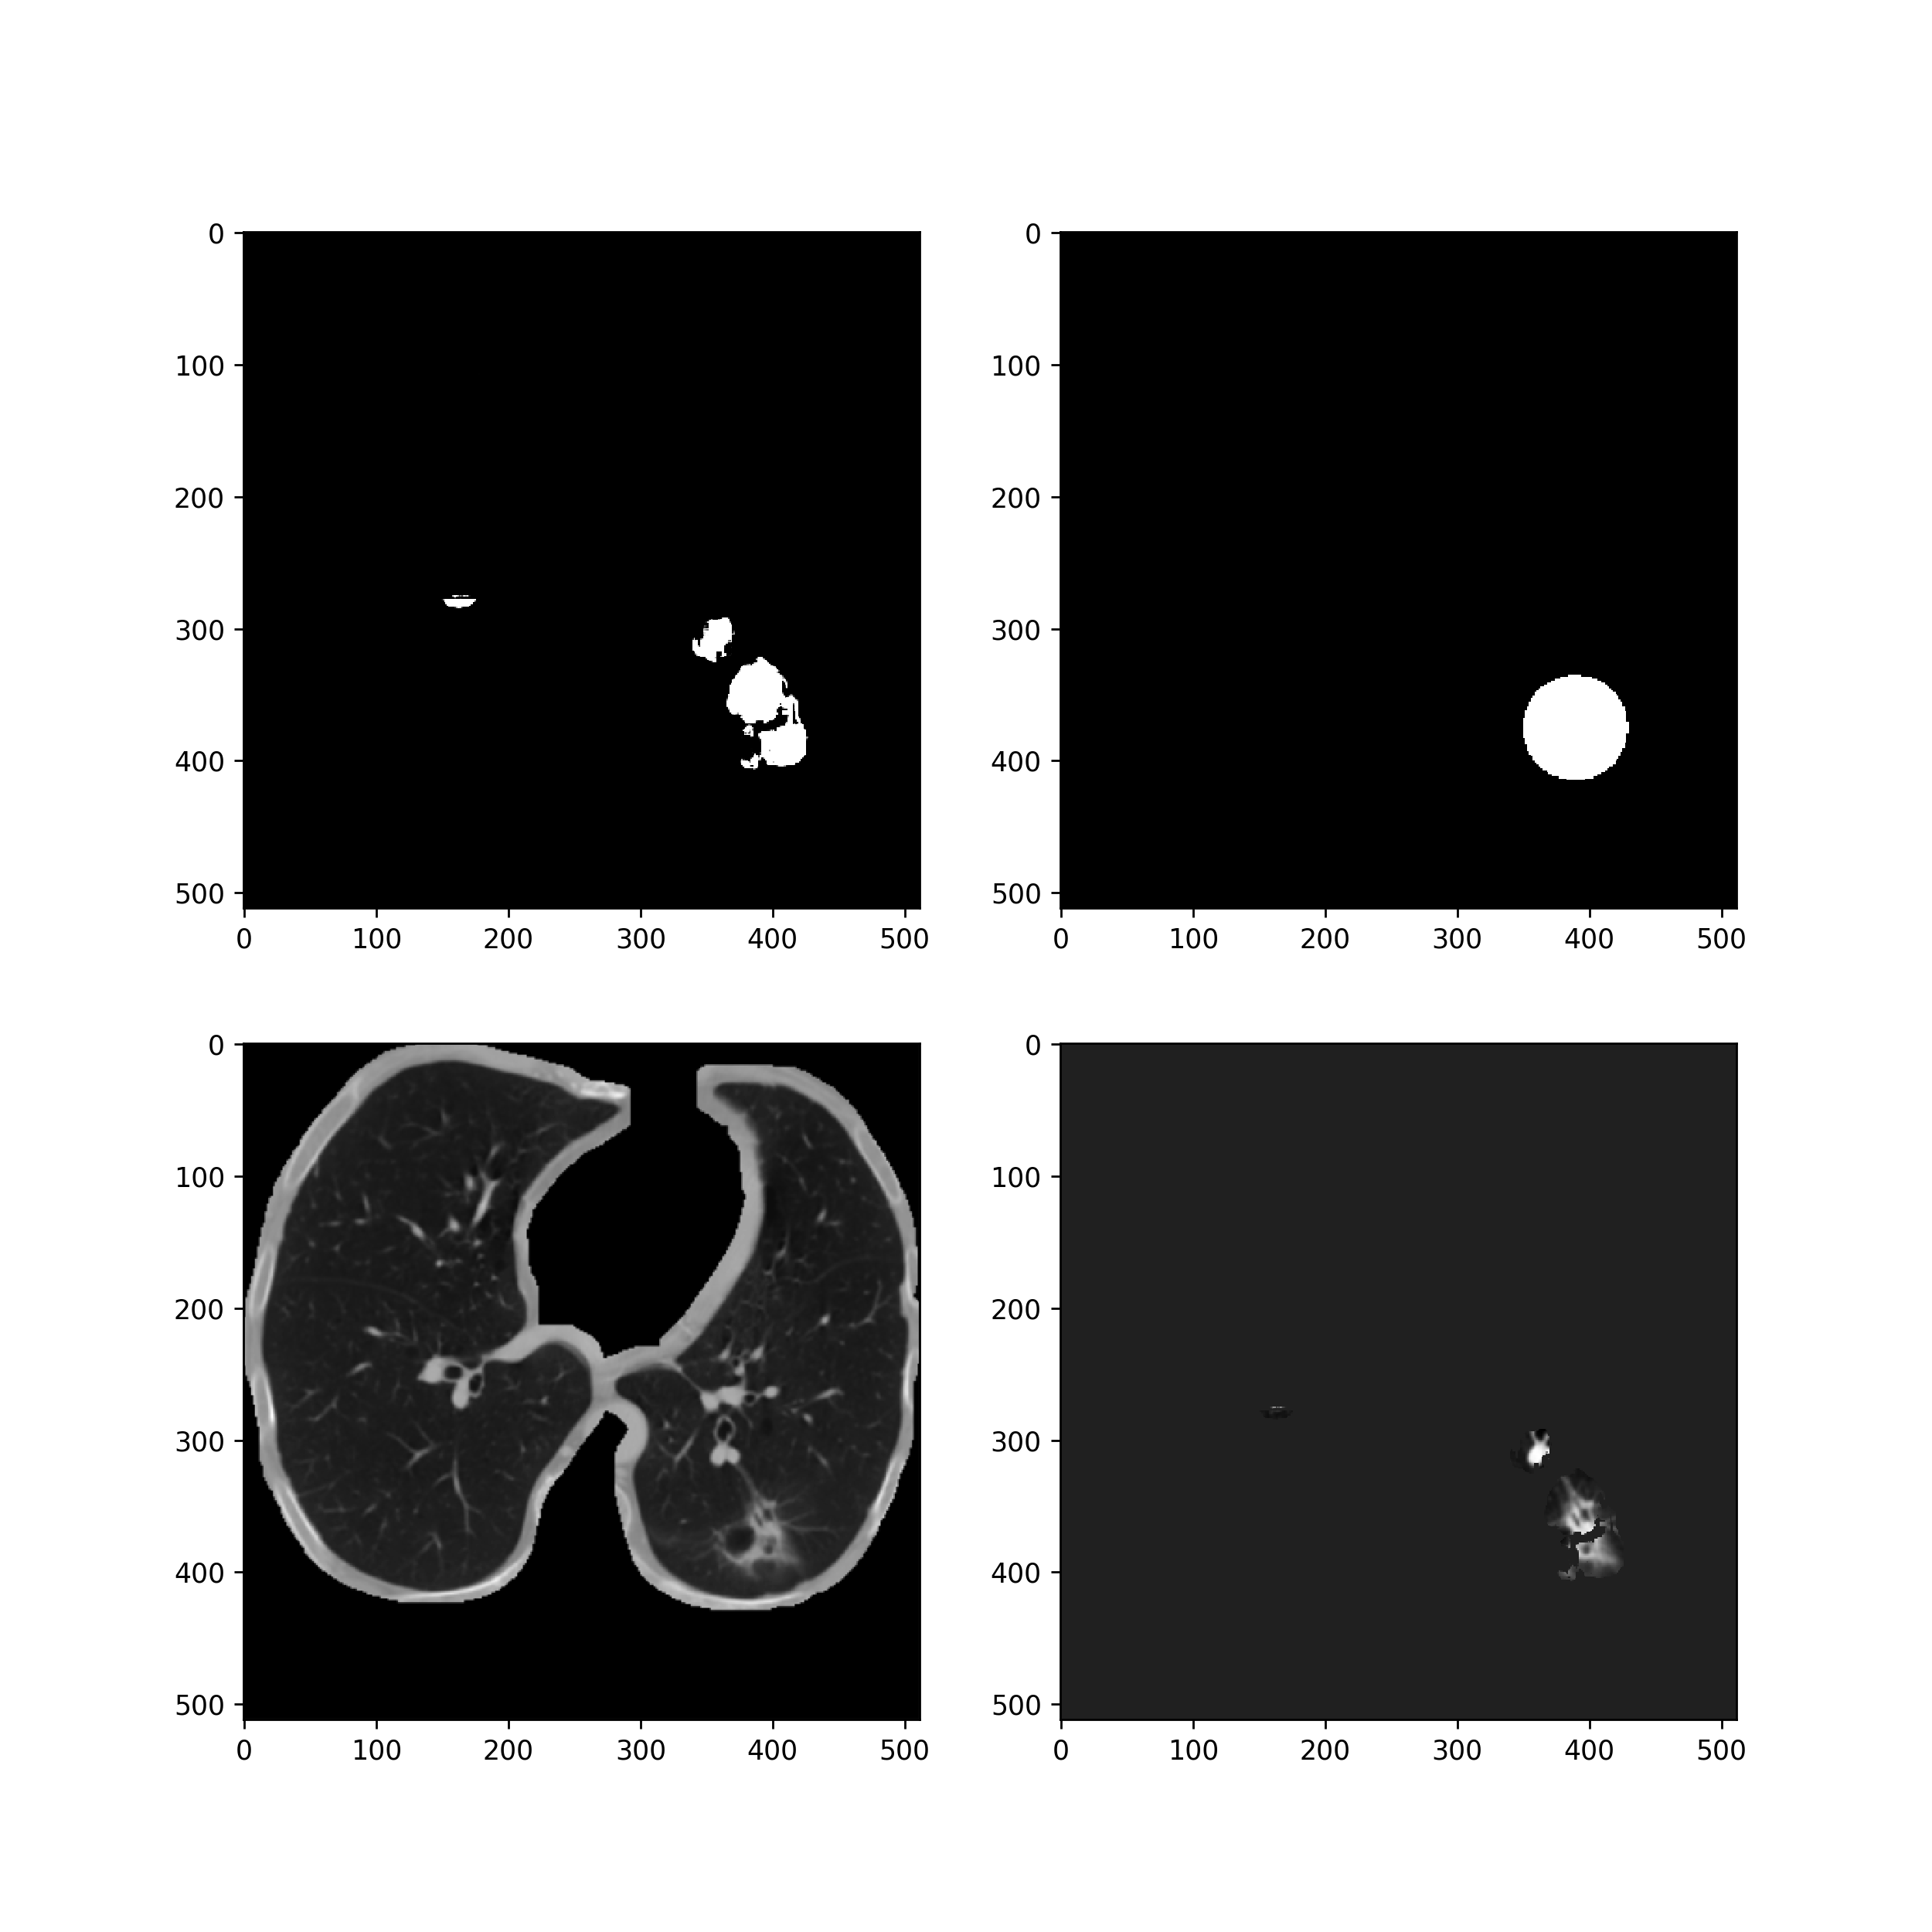

image 46


<IPython.core.display.Javascript object>


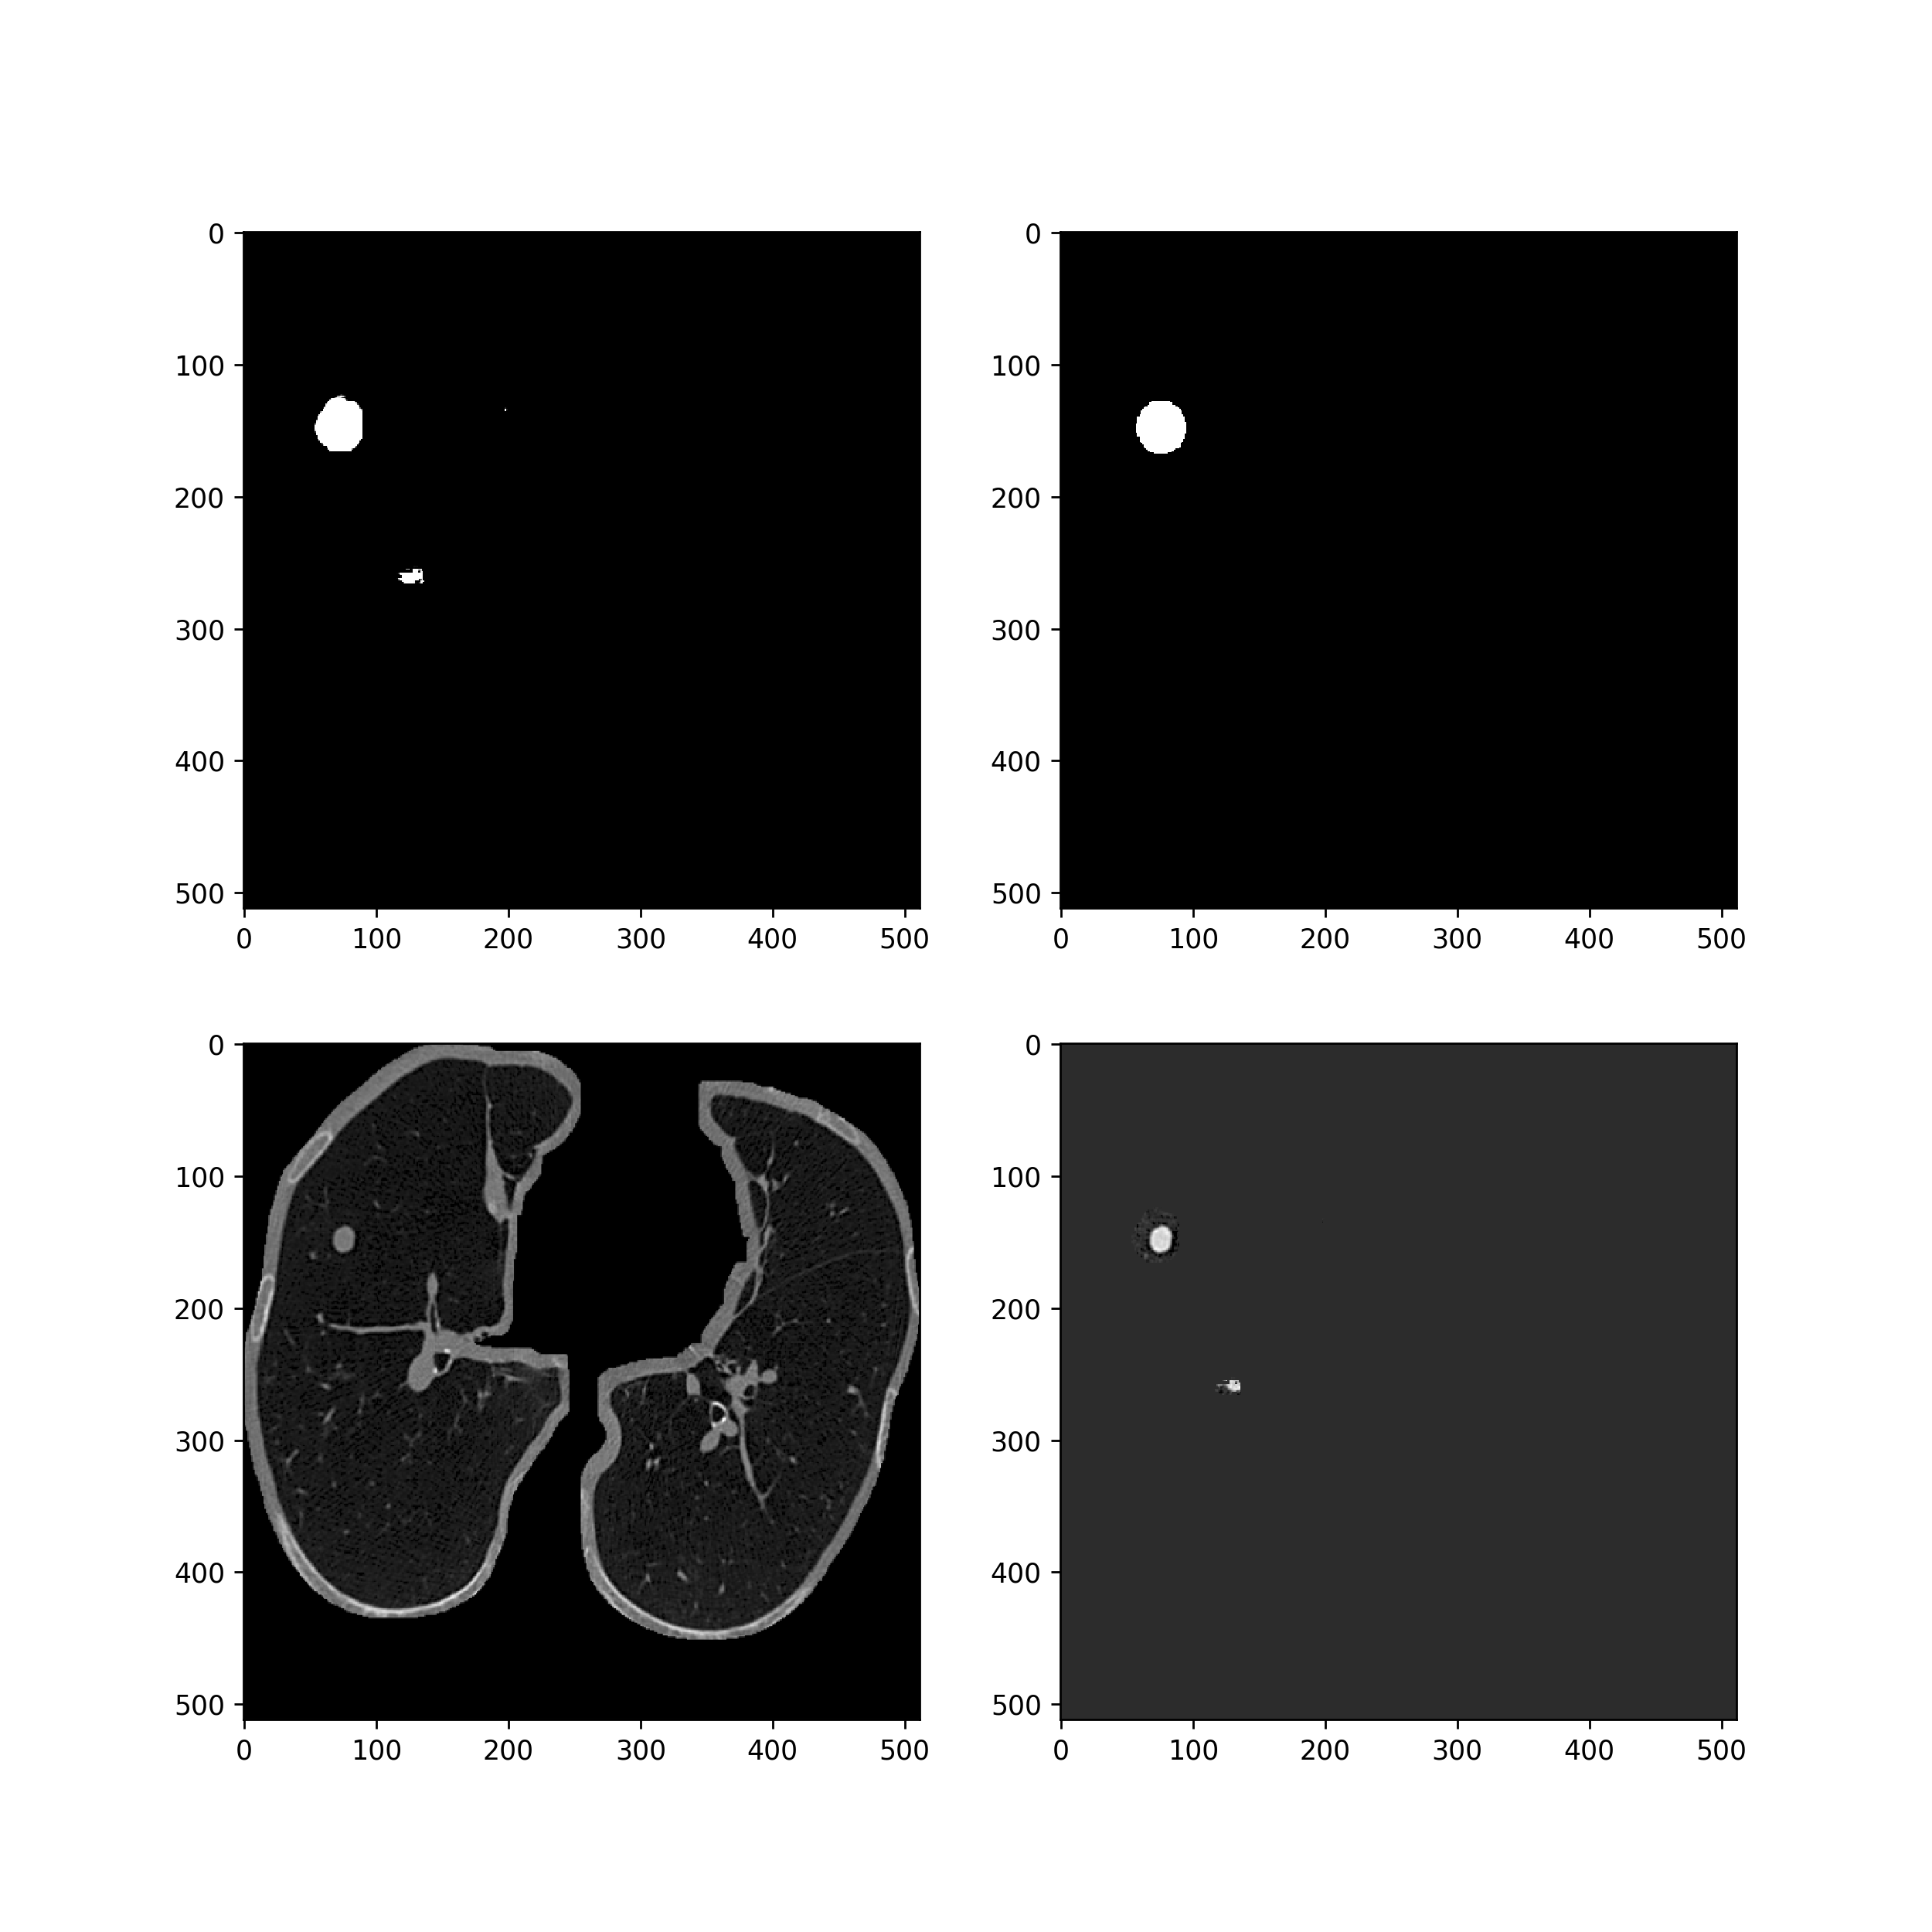

image 47


<IPython.core.display.Javascript object>


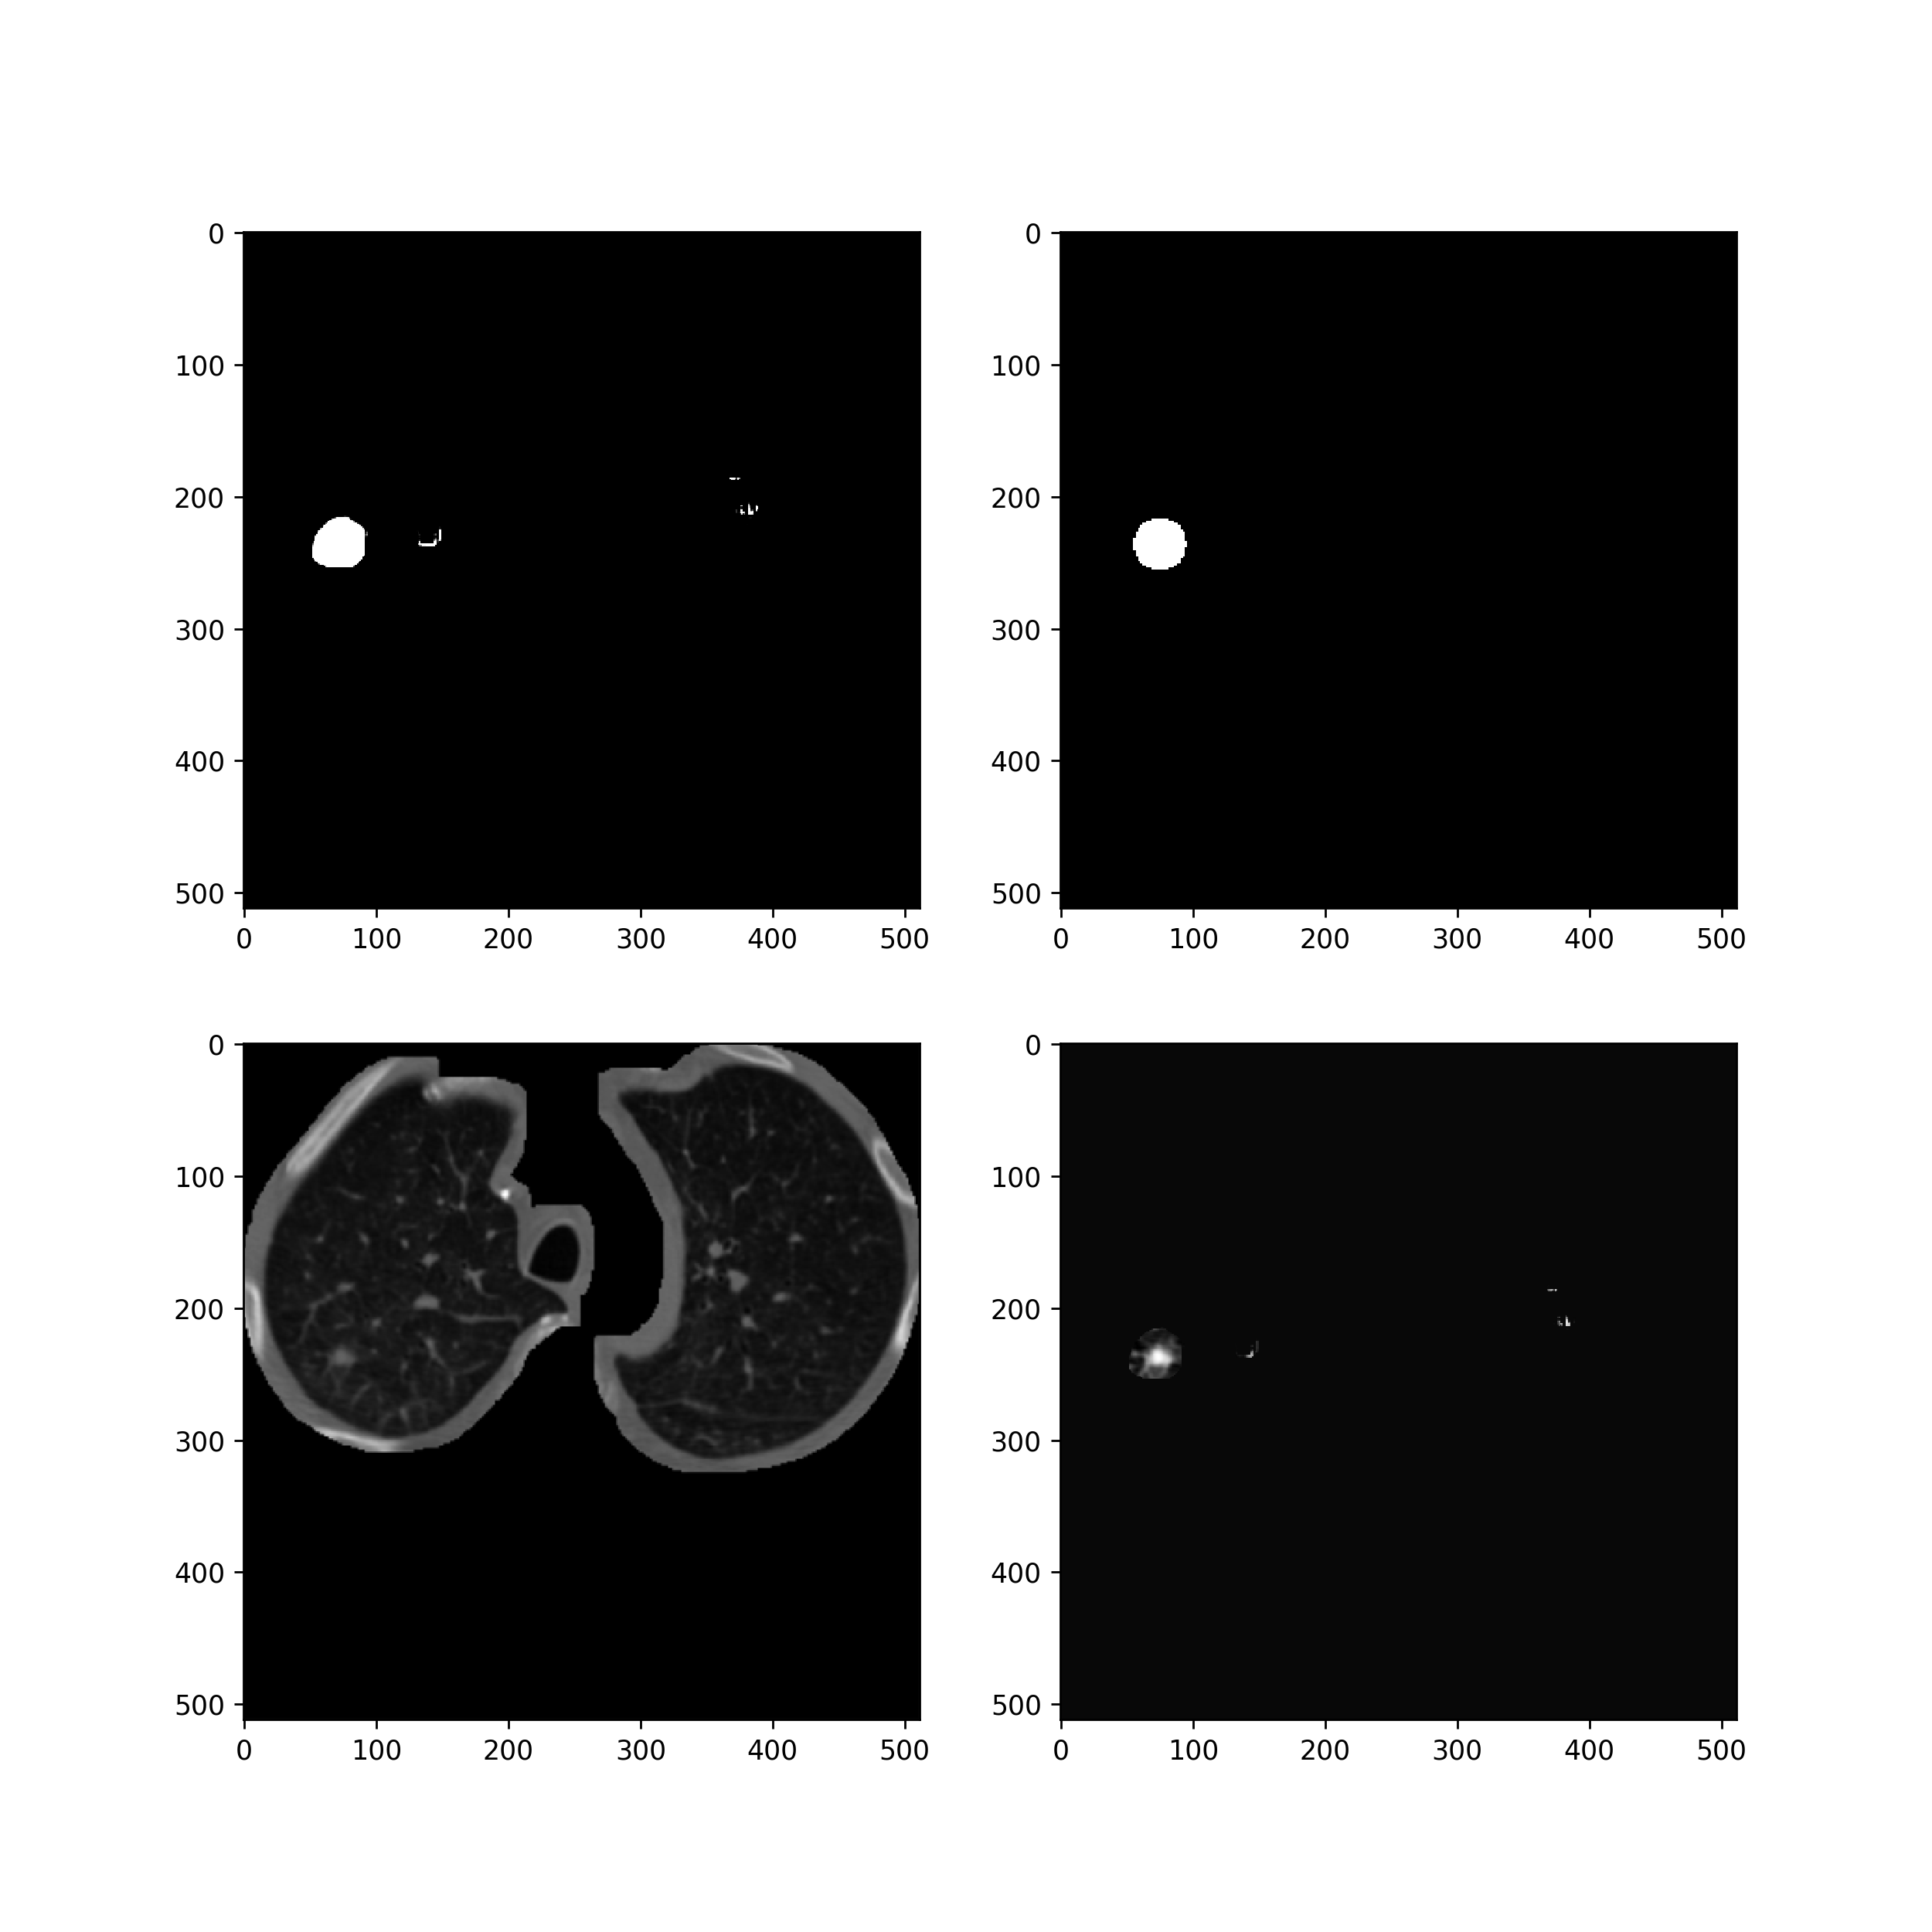

image 48


<IPython.core.display.Javascript object>


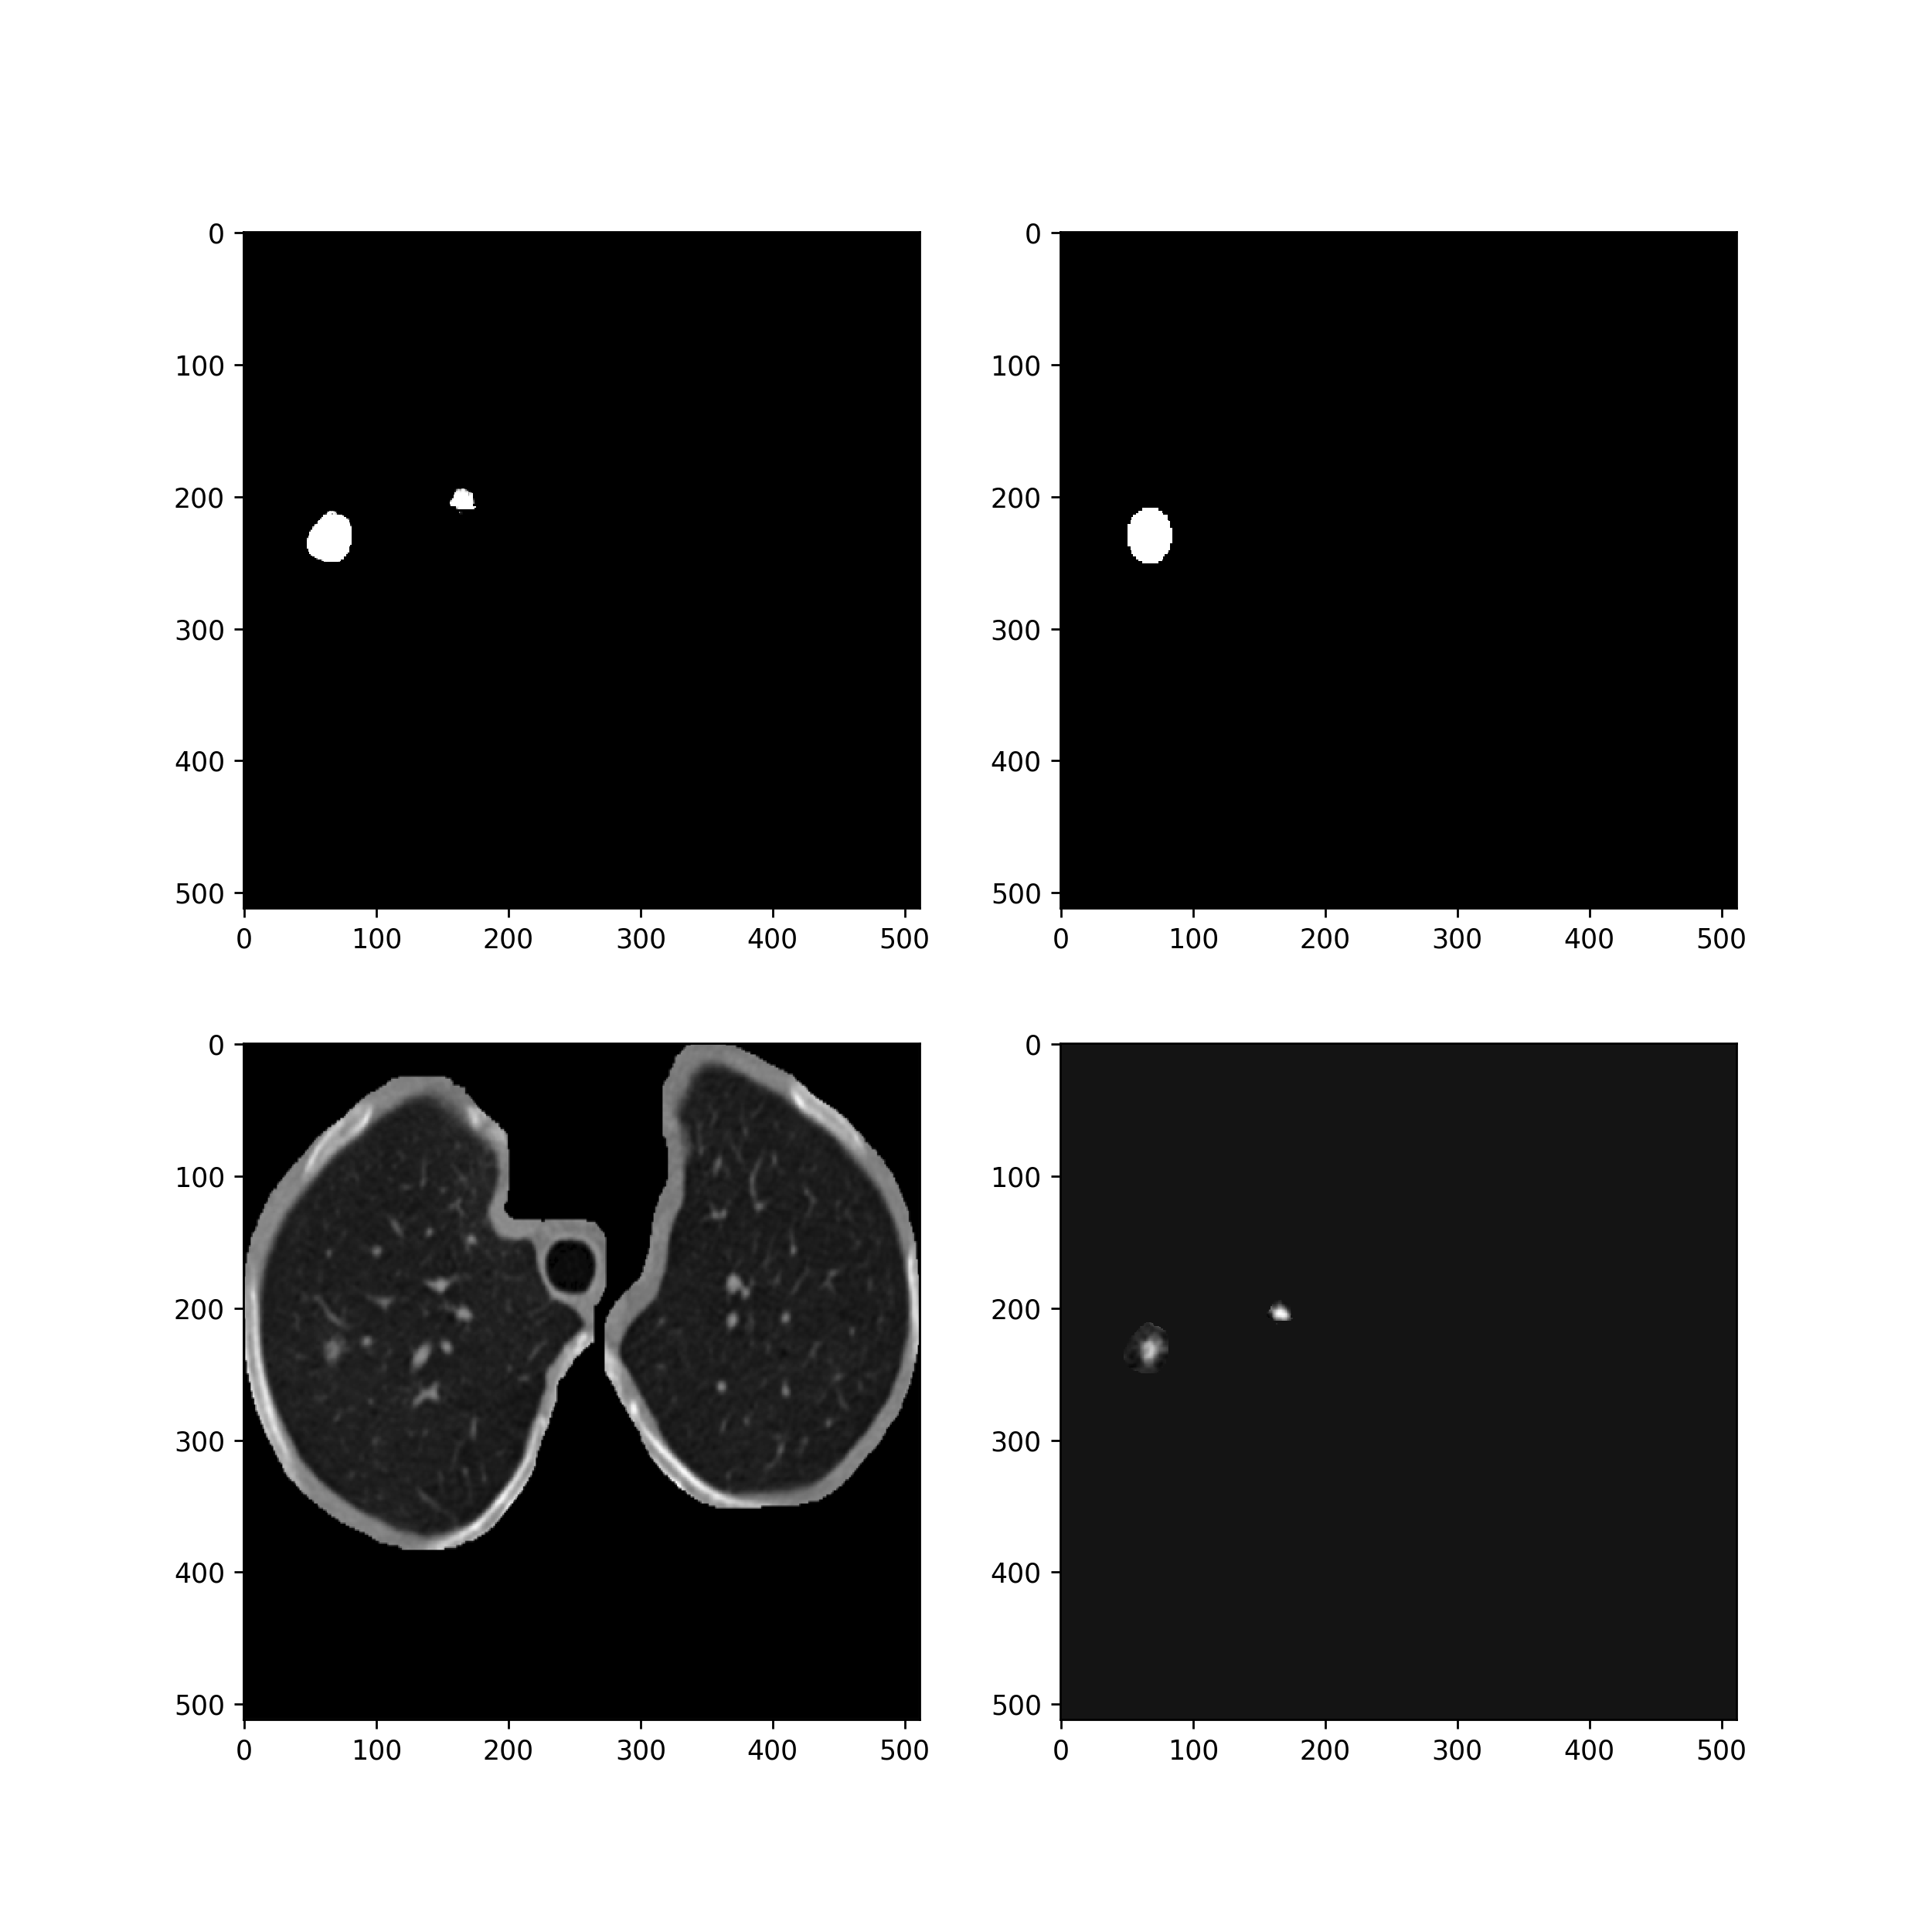

image 49


<IPython.core.display.Javascript object>


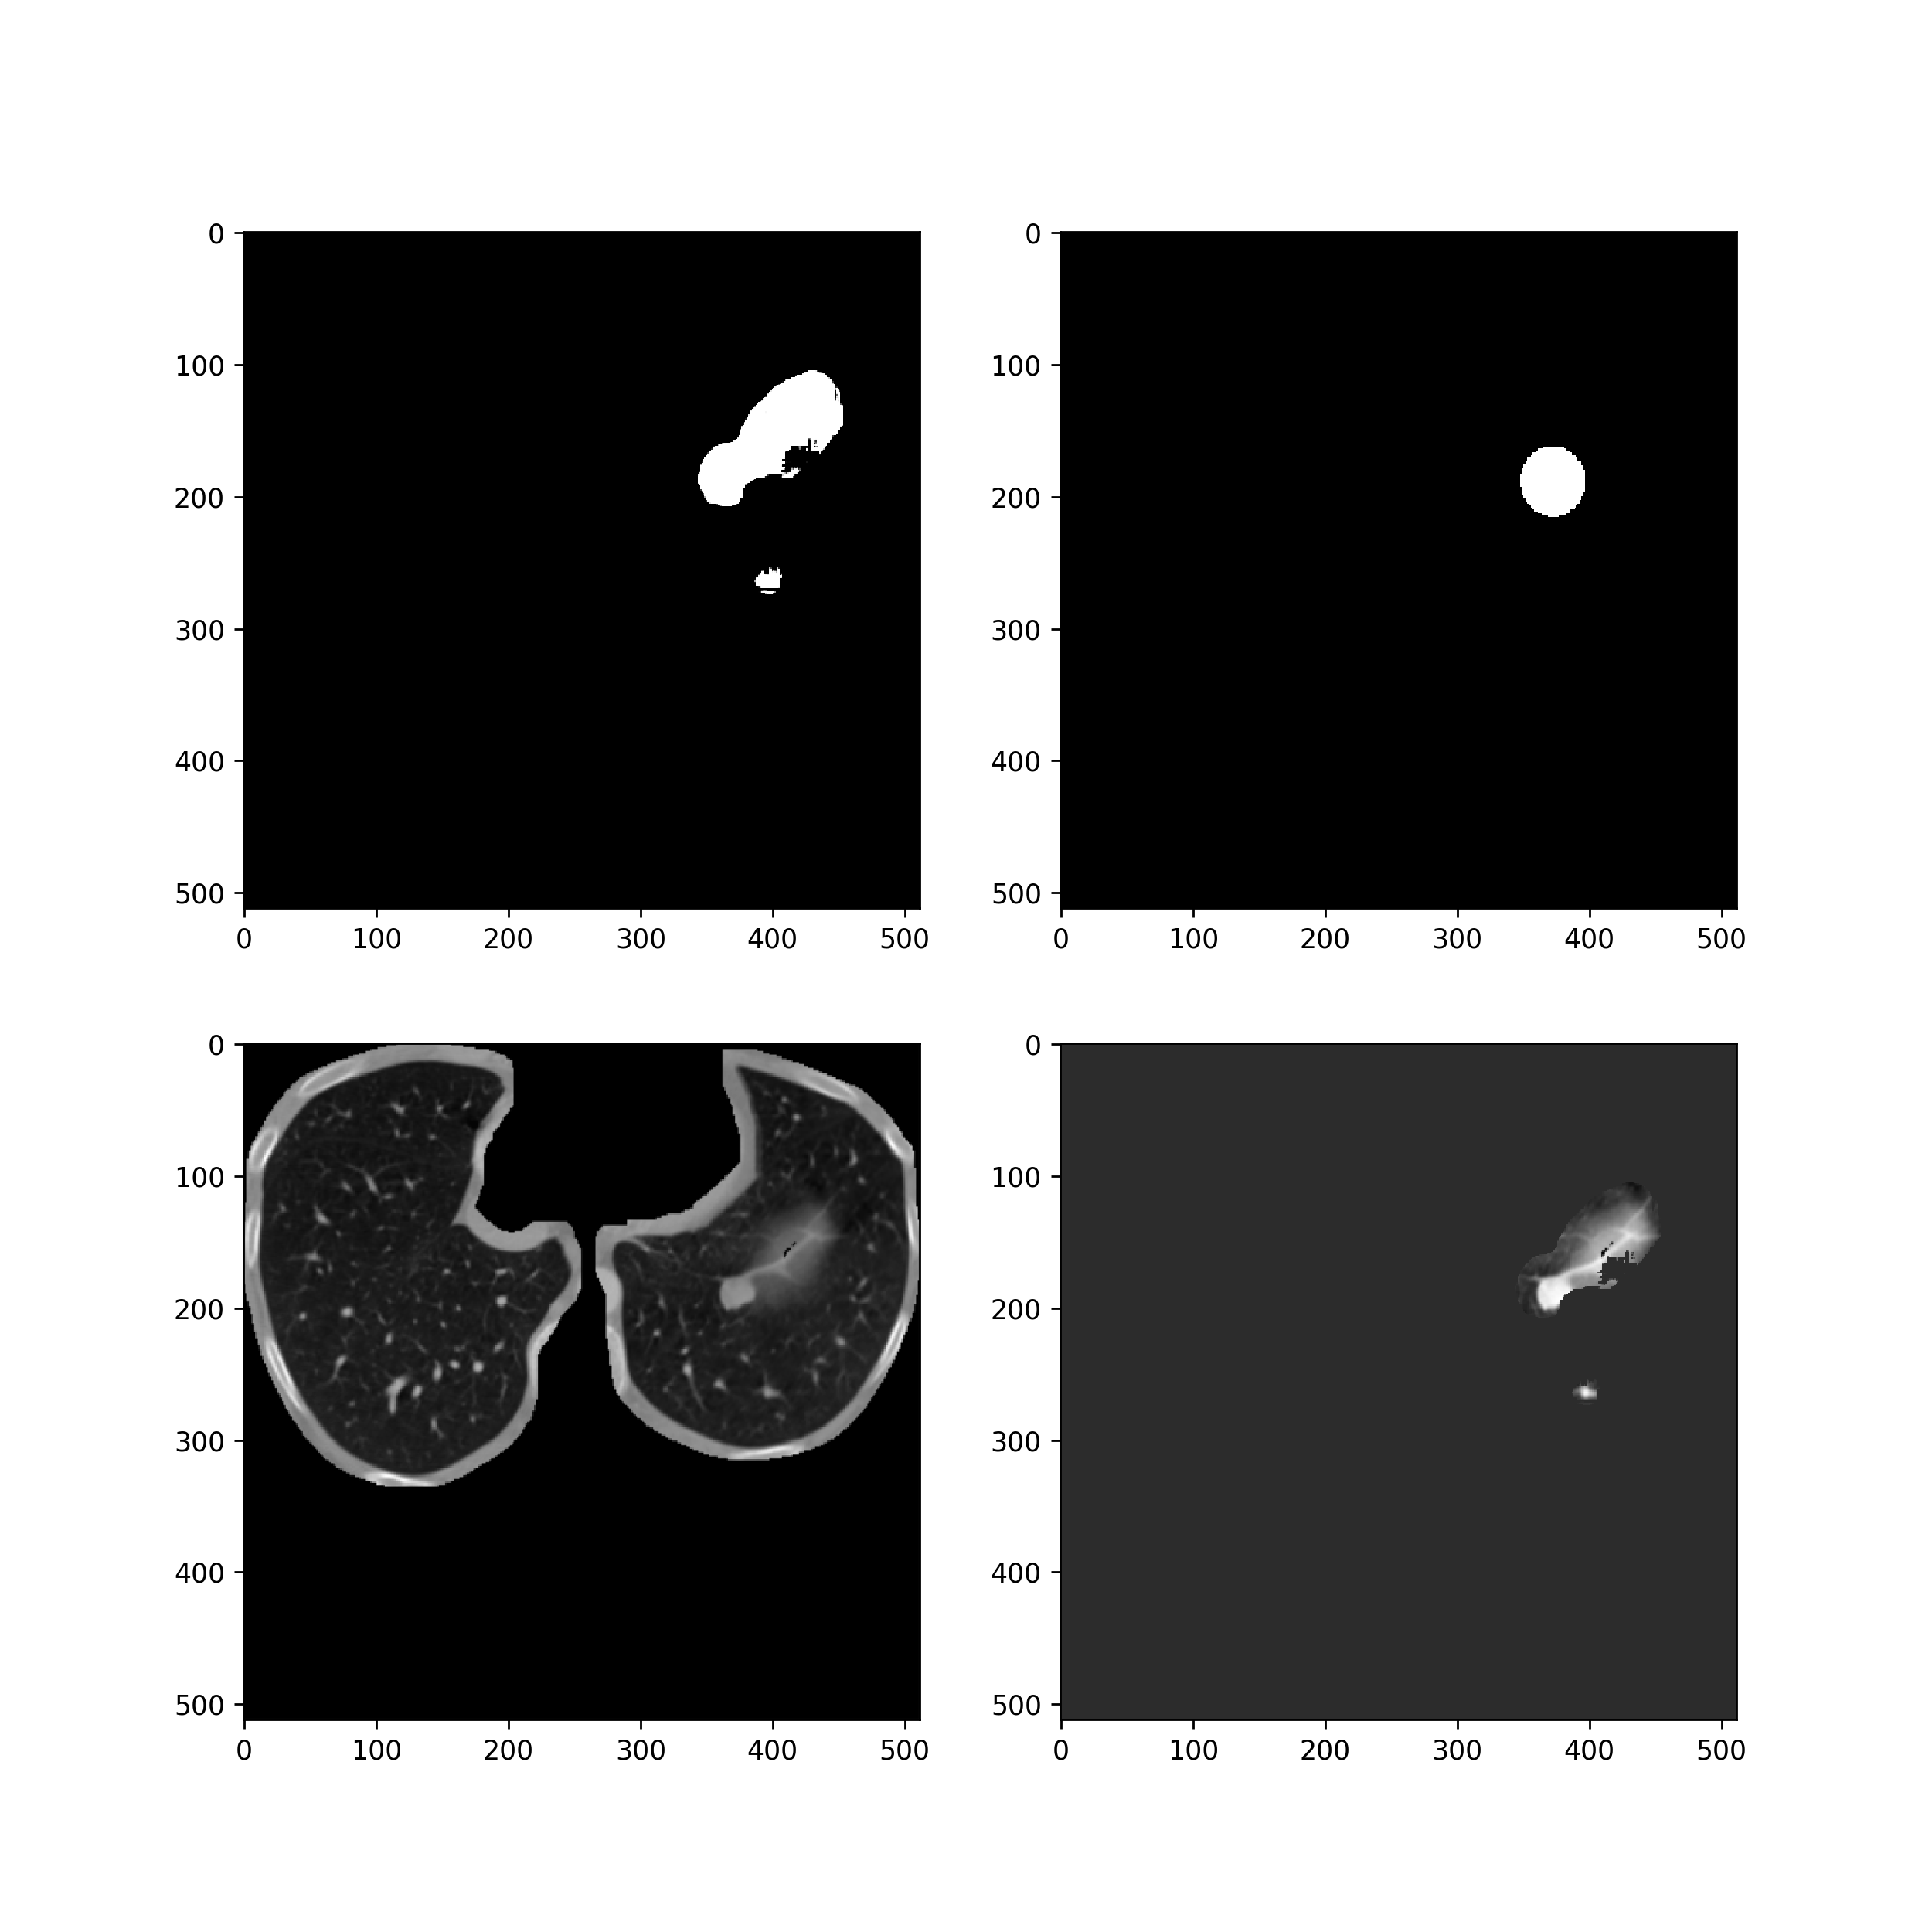

image 50


<IPython.core.display.Javascript object>


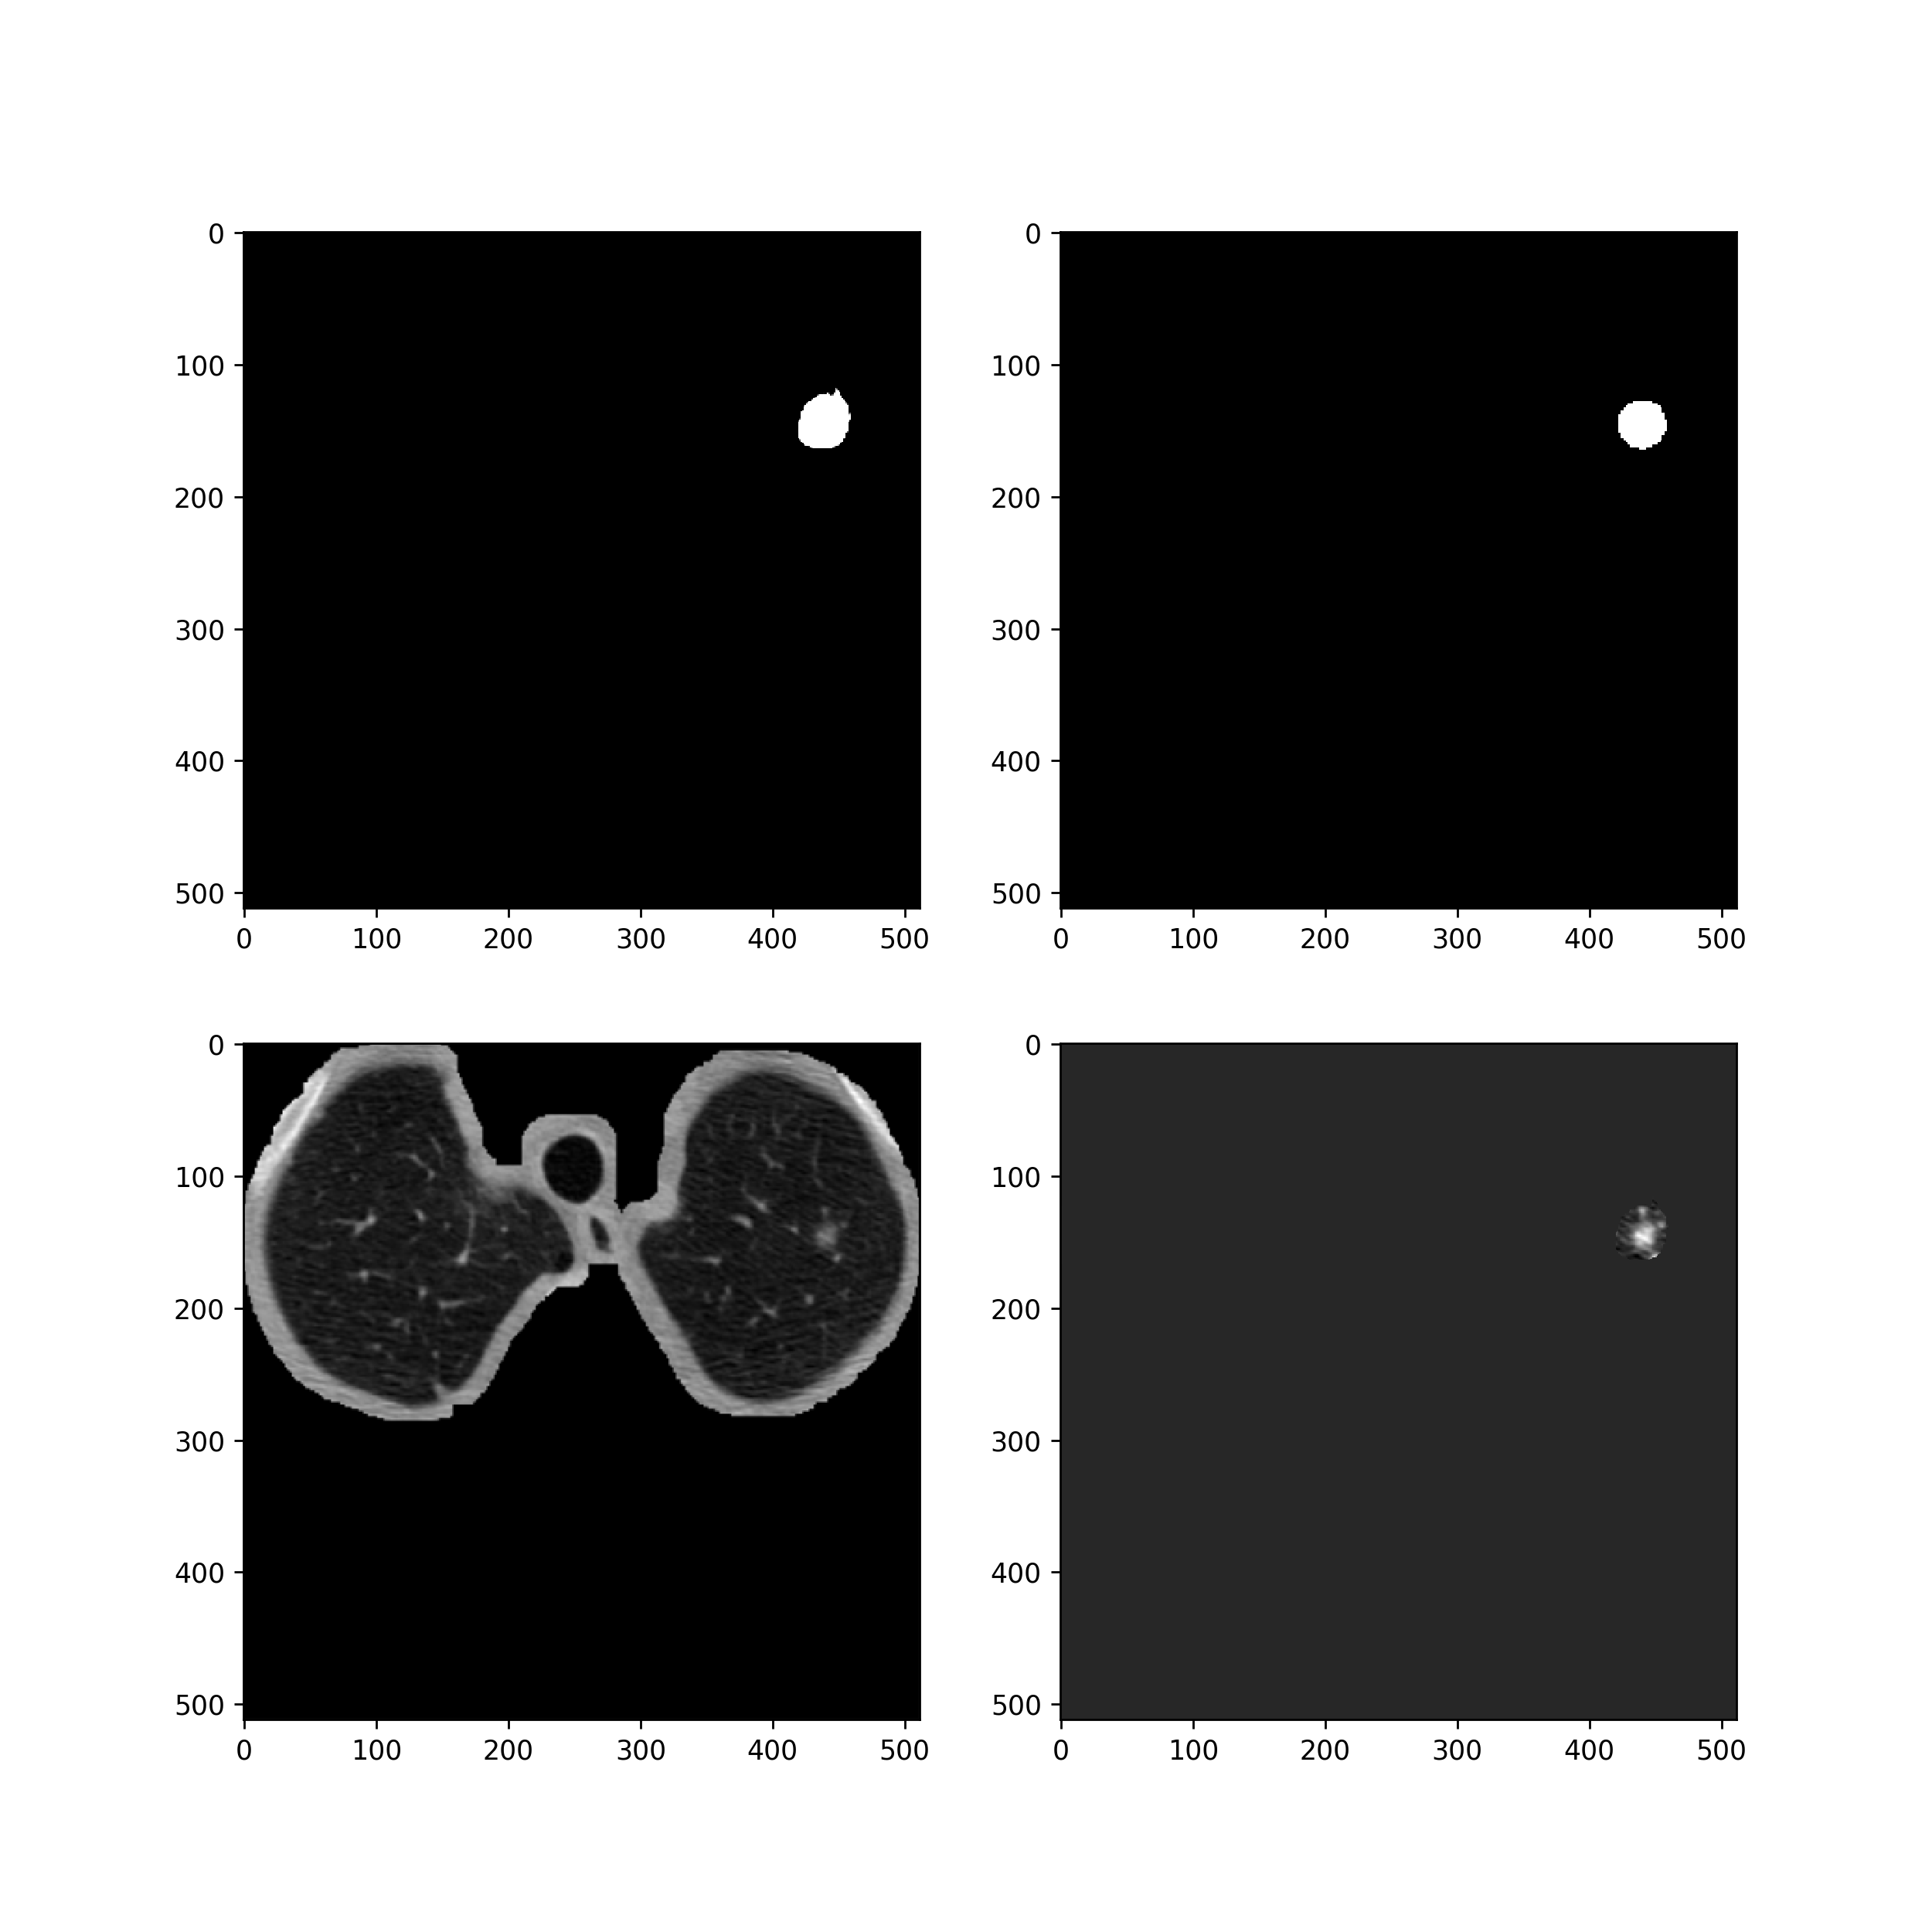

image 51


<IPython.core.display.Javascript object>


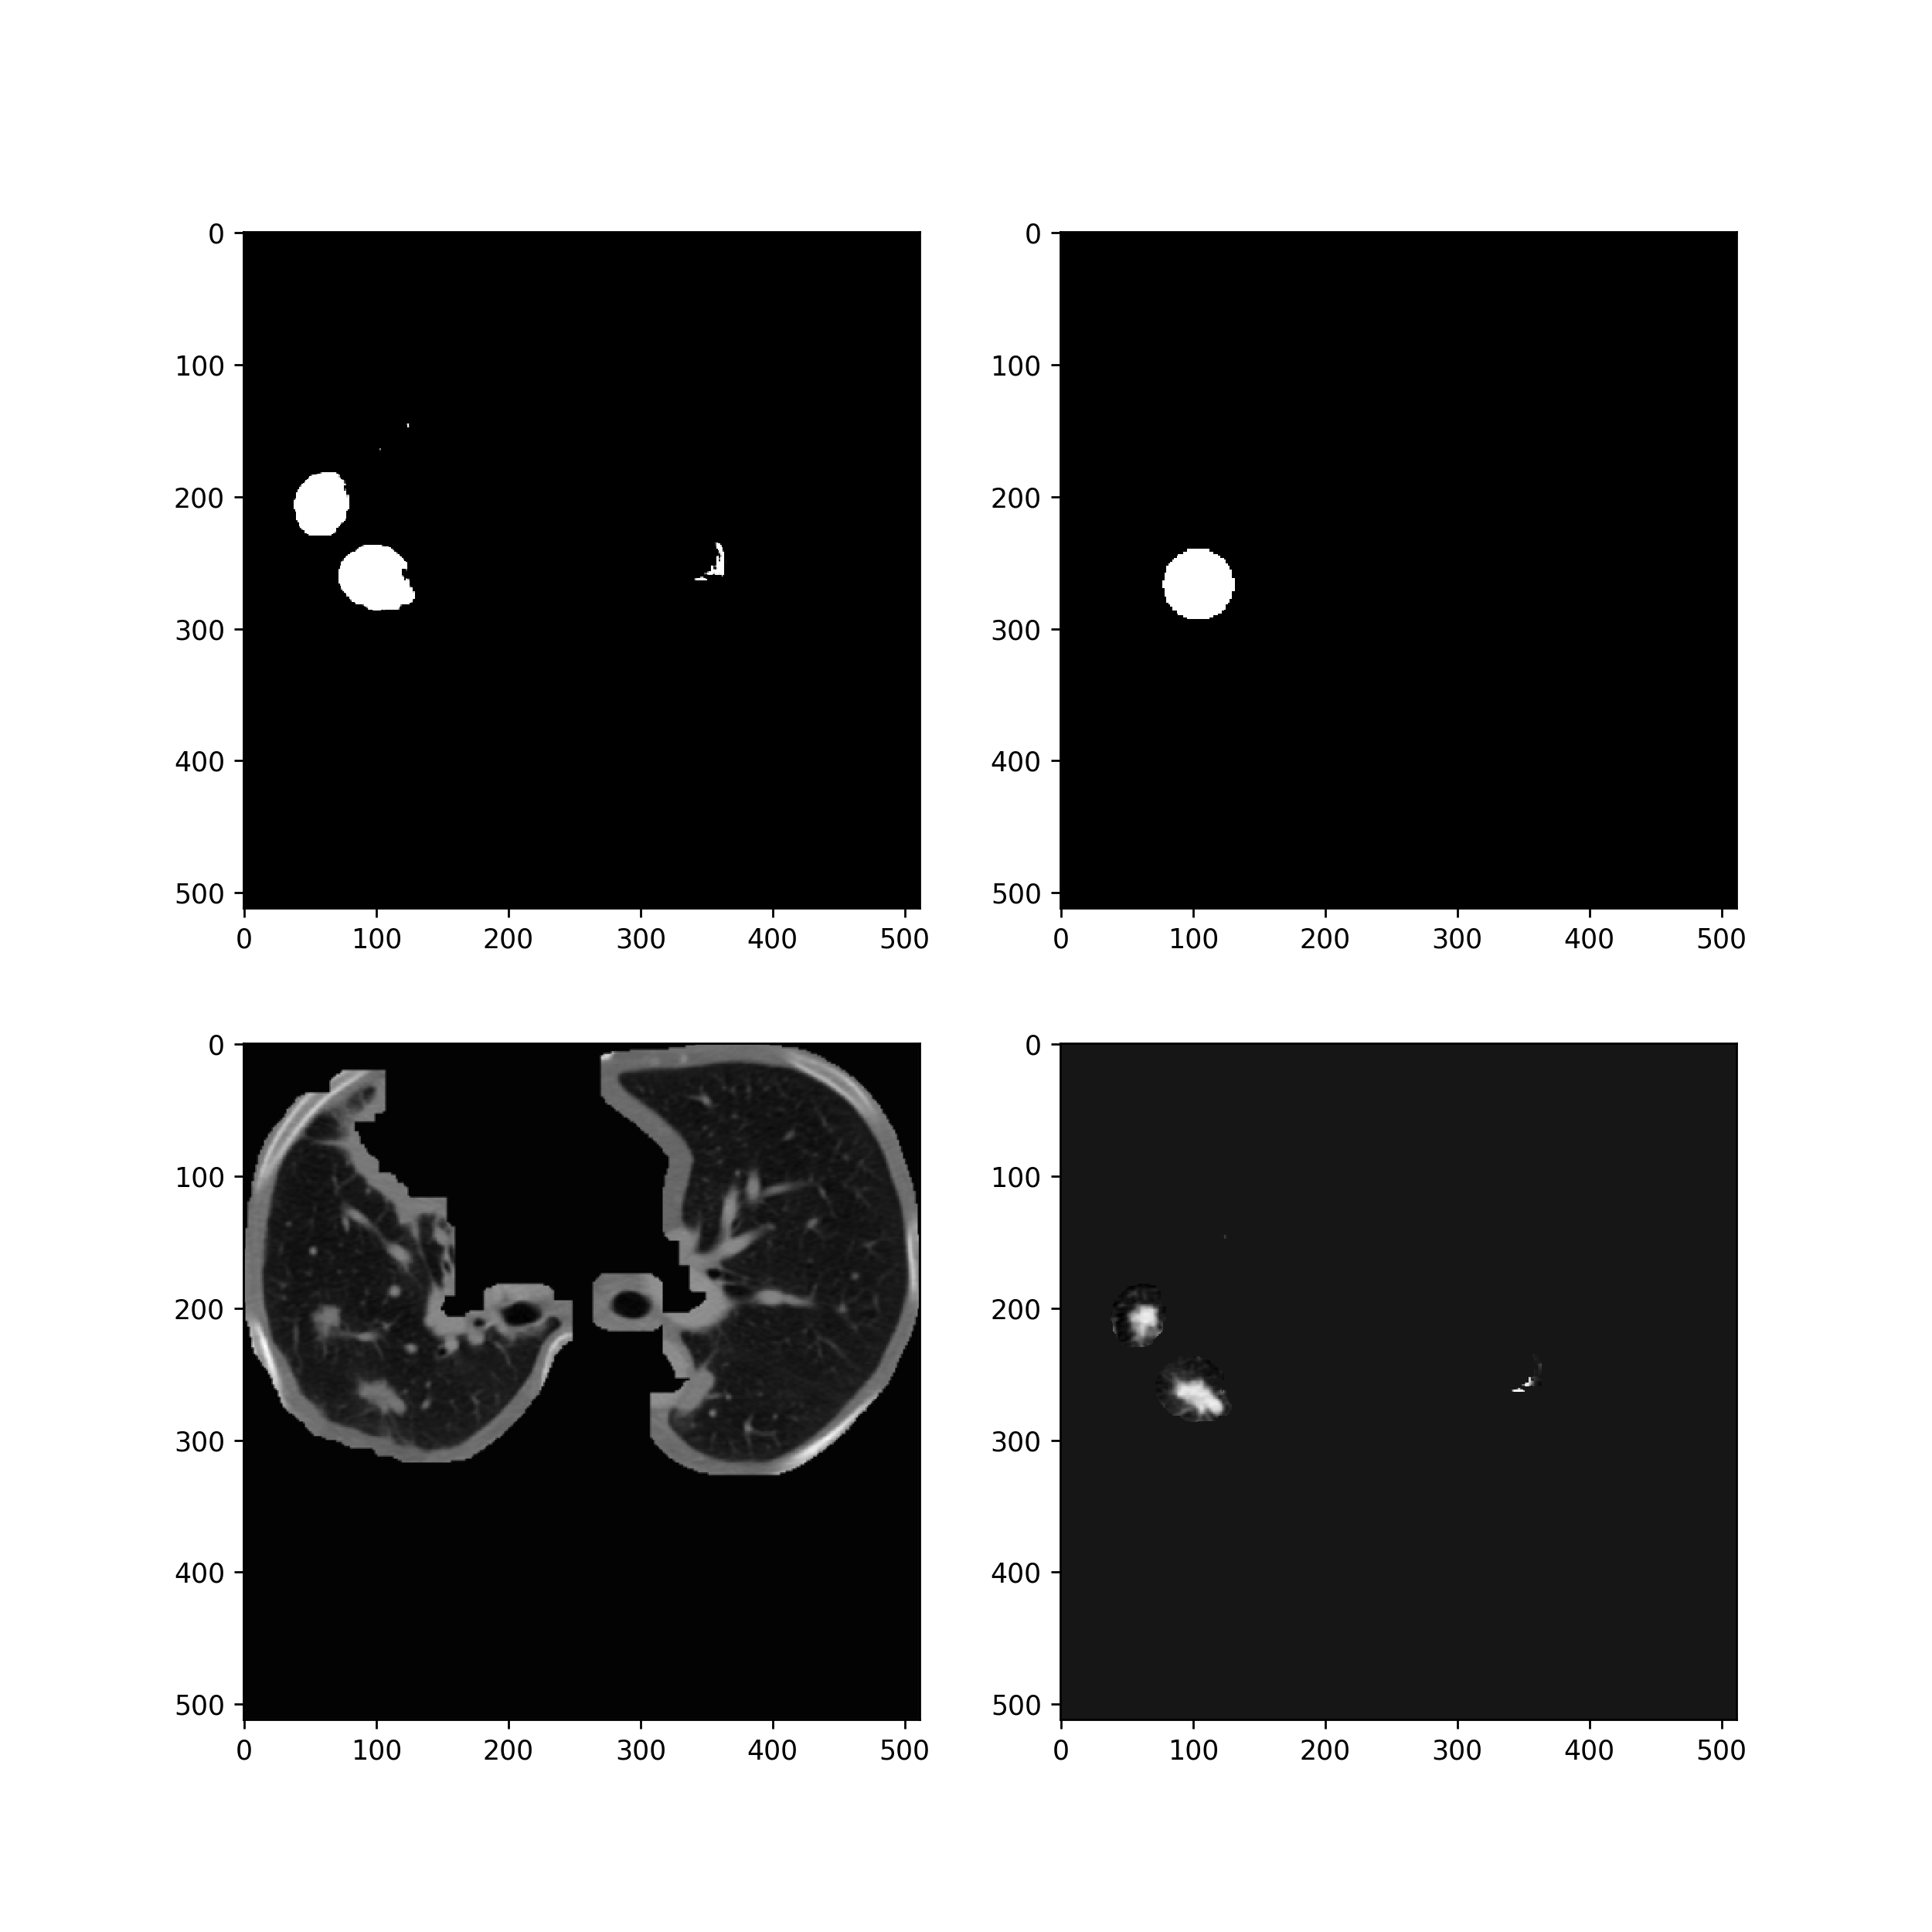

image 52


<IPython.core.display.Javascript object>


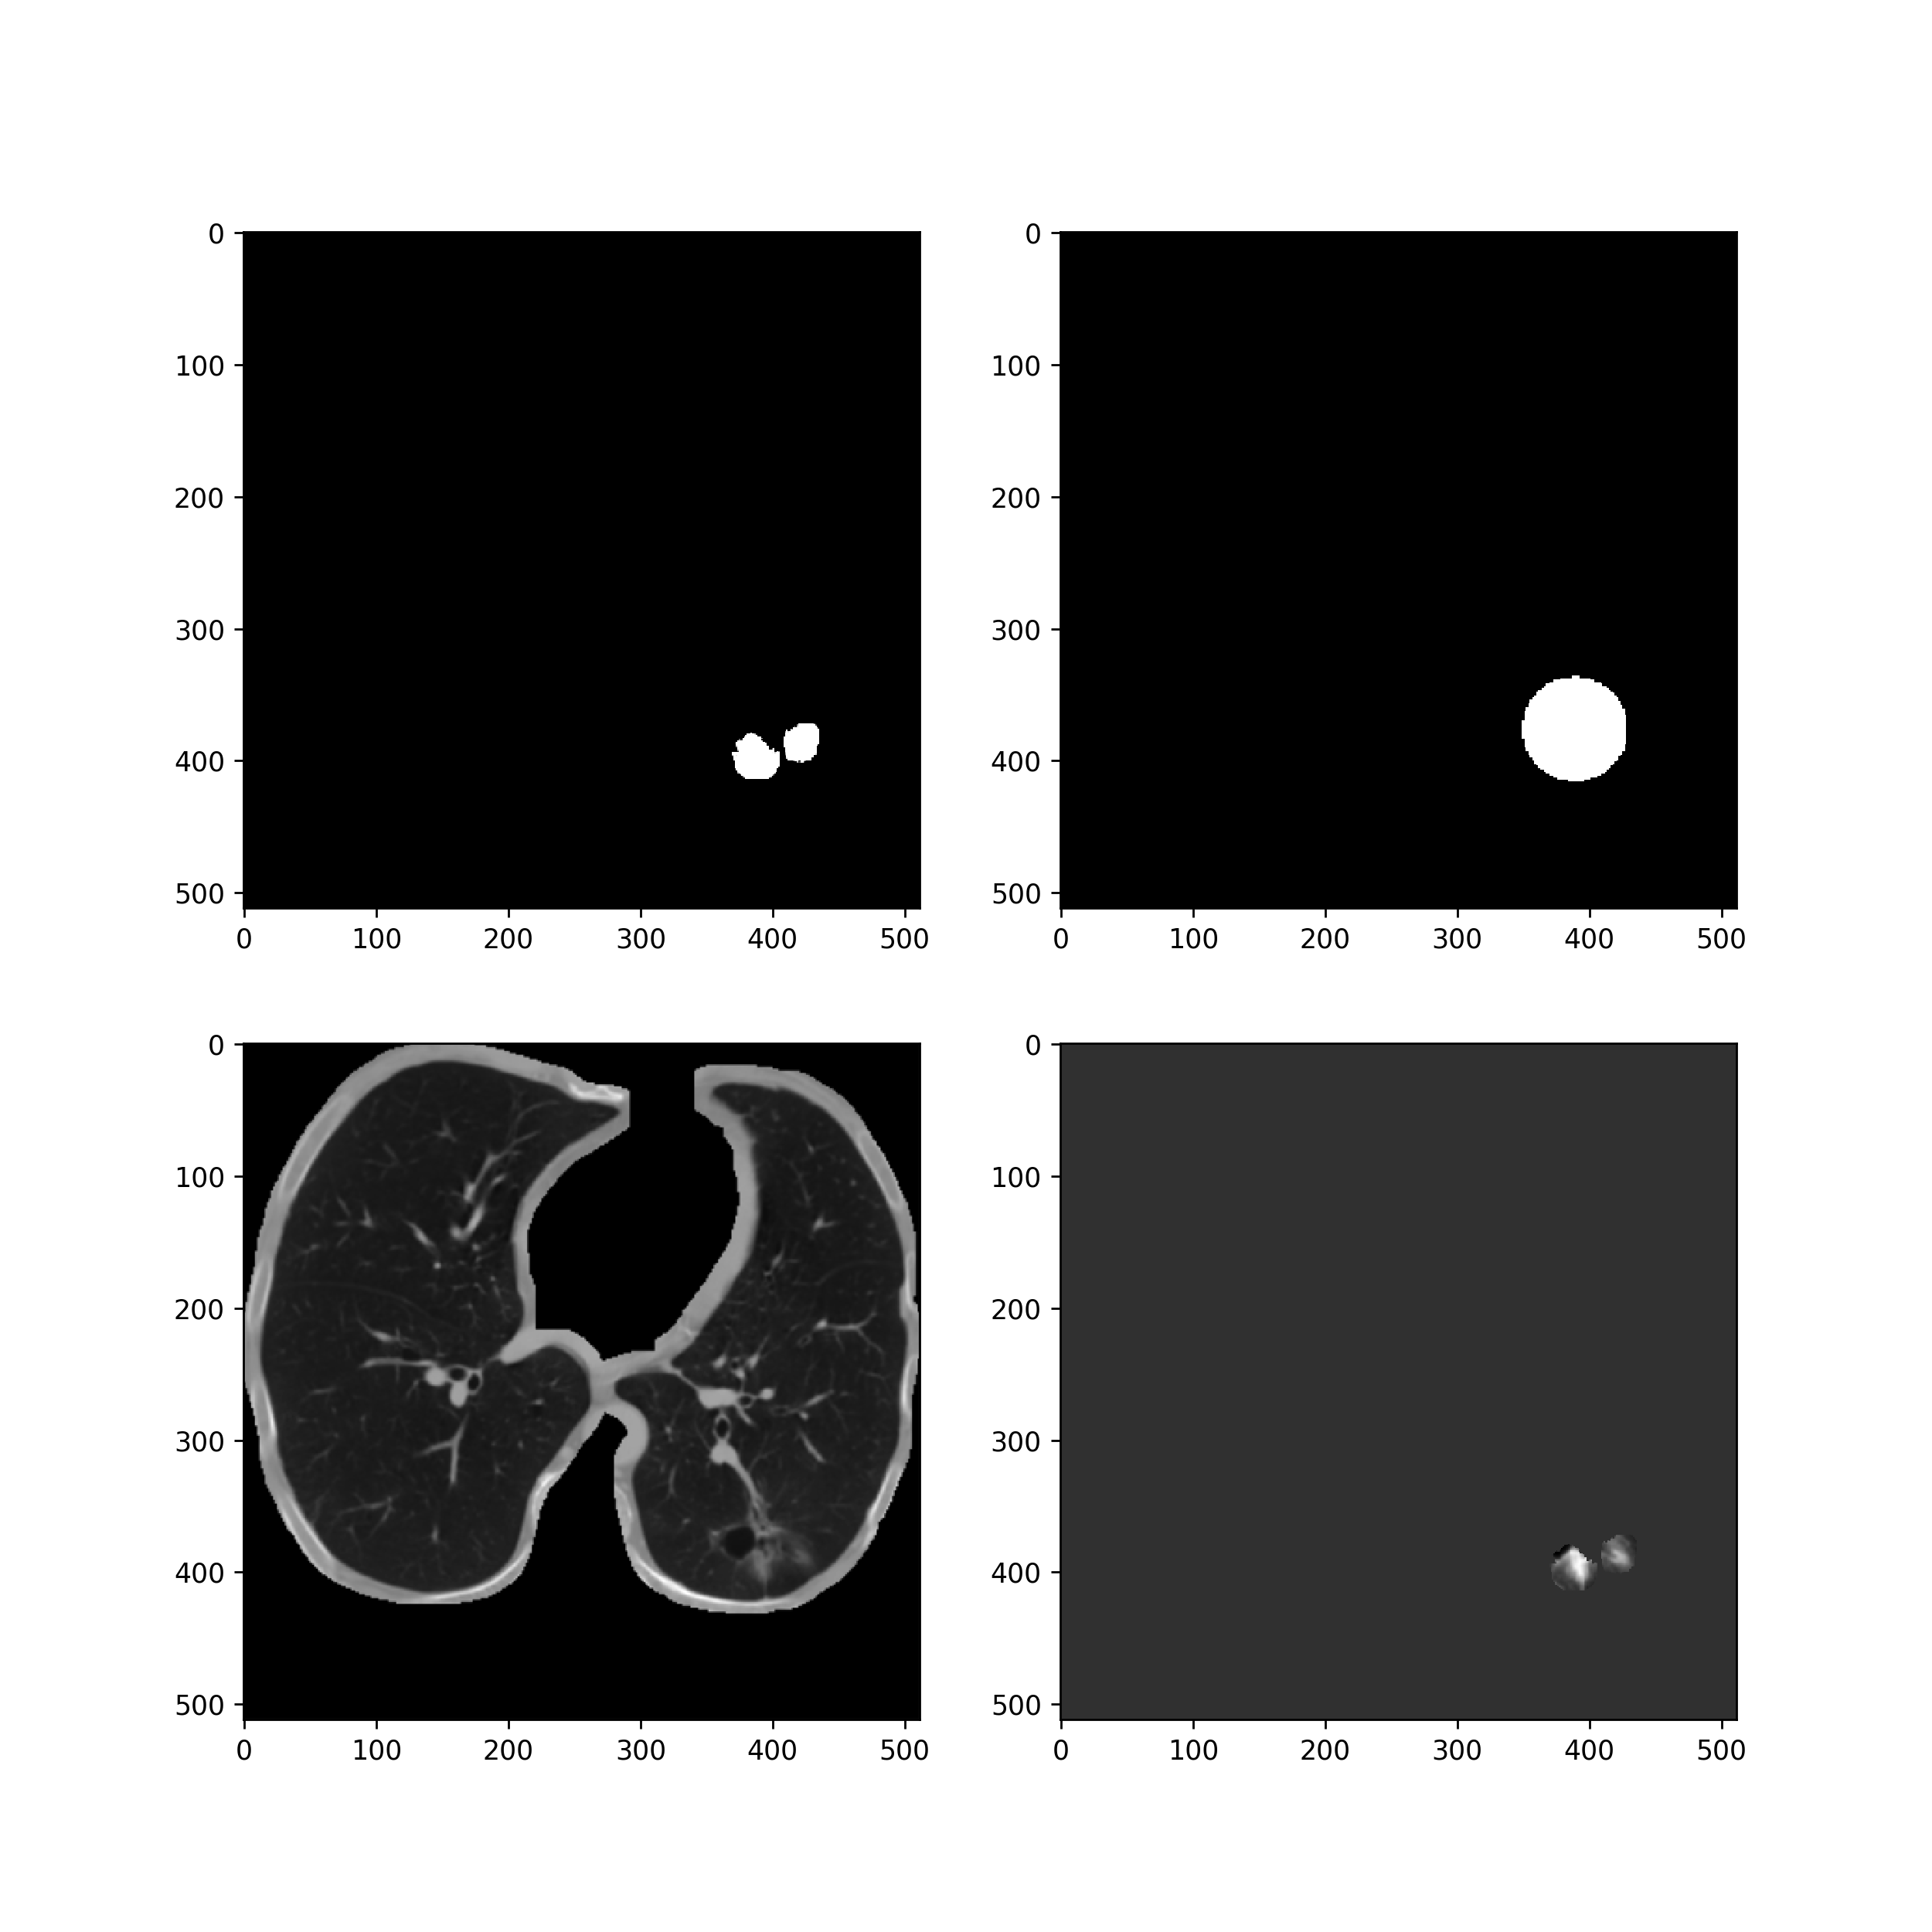

image 53


<IPython.core.display.Javascript object>


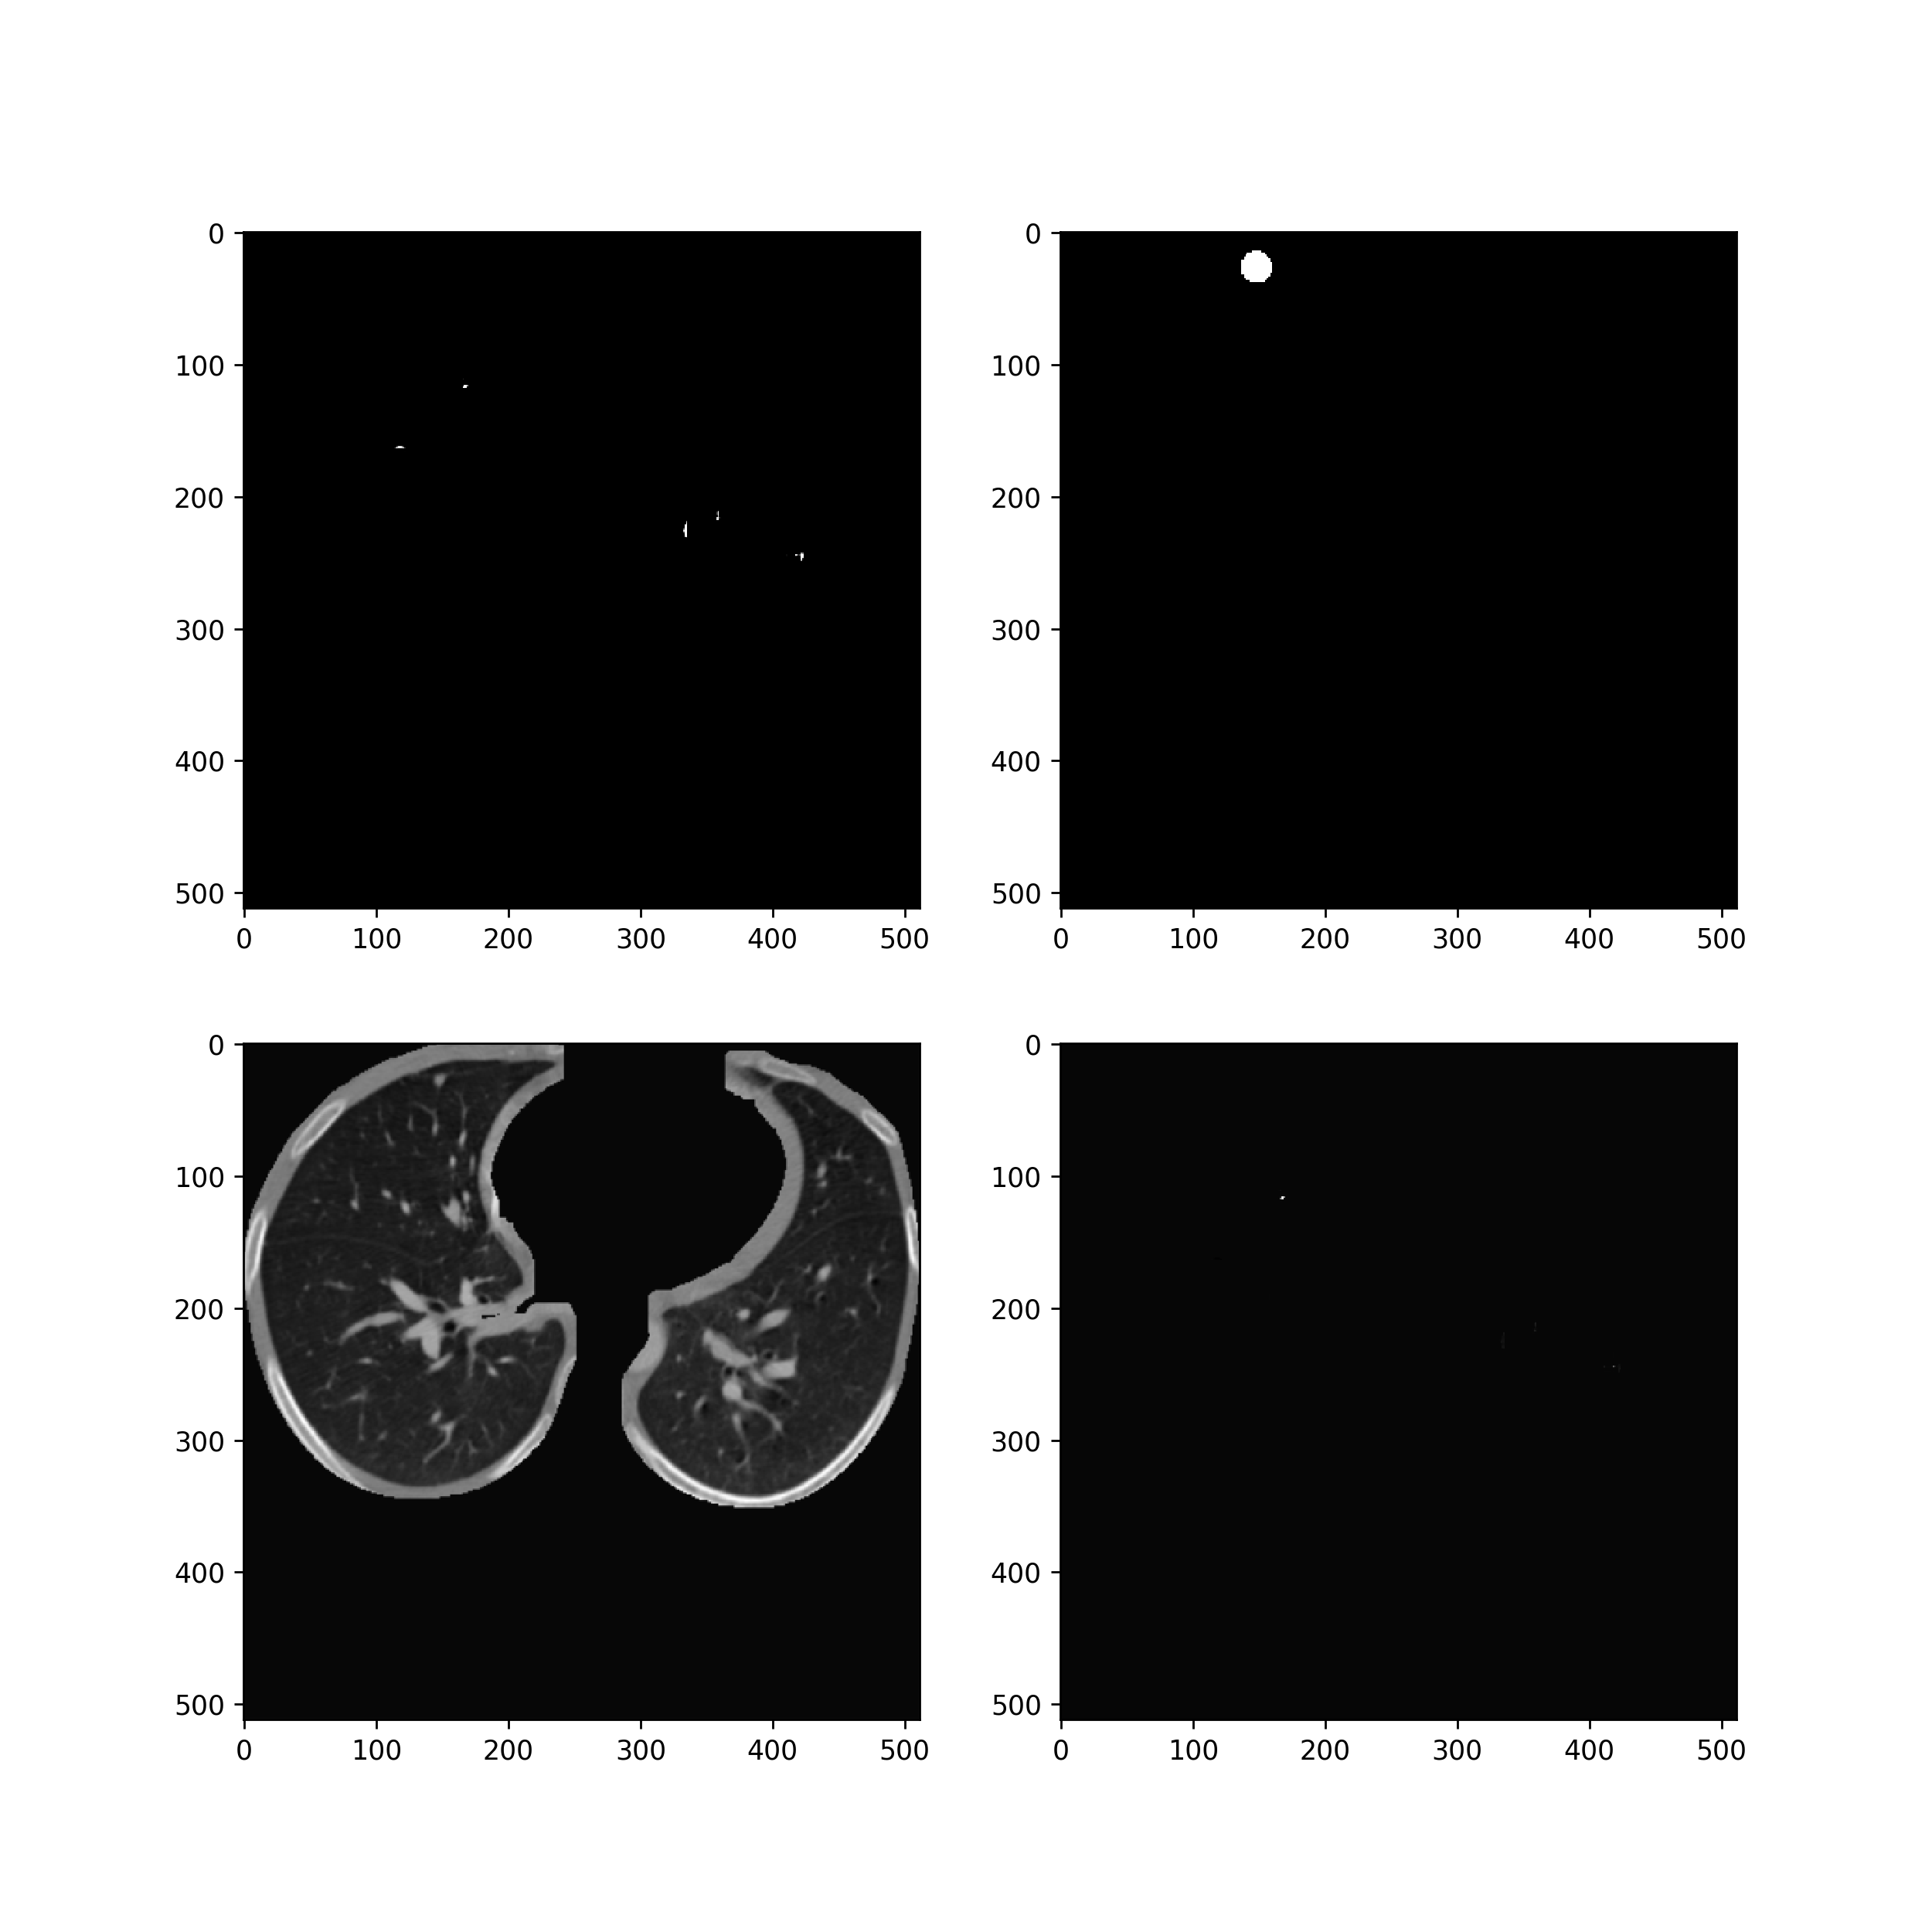

image 54


<IPython.core.display.Javascript object>


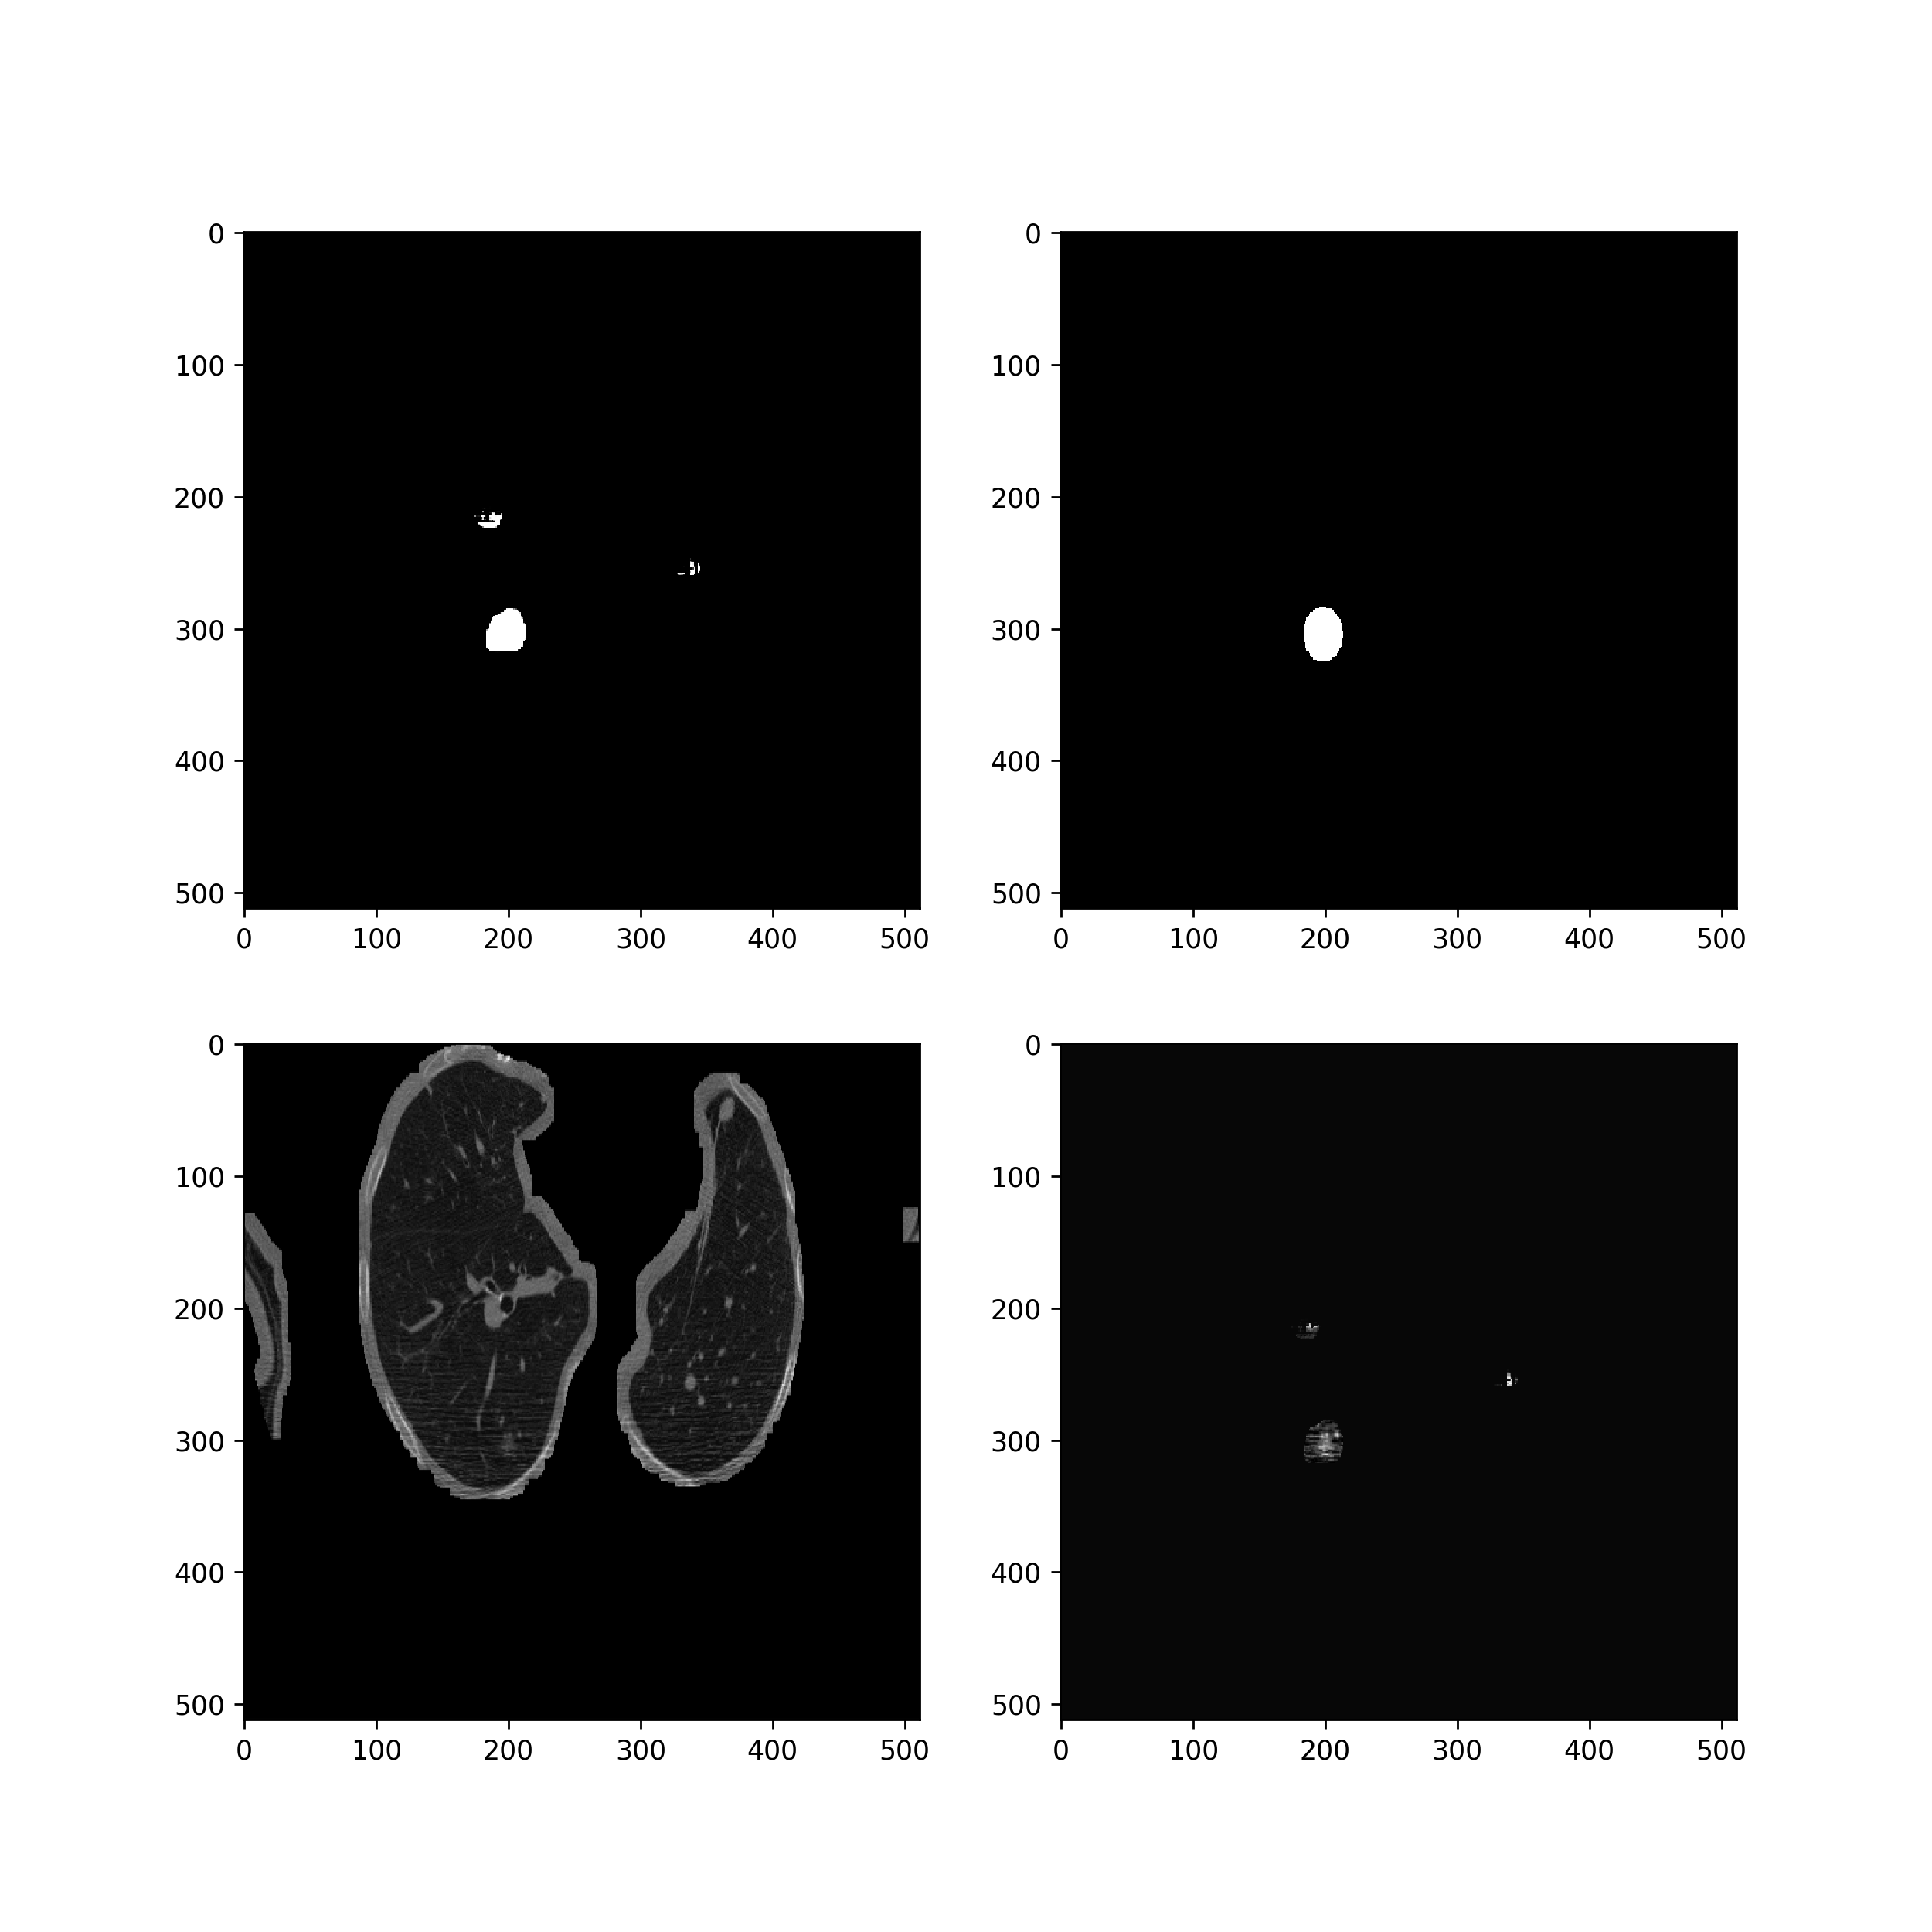

In [11]:
%matplotlib notebook

pred_masks = 'nicemasks.npy'
label_masks = '../outs/testMasks.npy'
test_imgs = '../outs/testImages.npy'

masks = np.load(pred_masks)
l_masks = np.load(label_masks)
l_imgs = np.load(test_imgs)

for i in range(45,55):
    print ("image %d" % i)
    
    fig,ax = plt.subplots(2,2,figsize=[10,10])
    
    ax[0,0].imshow(masks[i,0],cmap='gray') #mascara nodulo annotations.csv correspondente
    ax[0,1].imshow(l_masks[i,0],cmap='gray') #mascara nodulo annotations.csv correspondente
    ax[1,0].imshow(l_imgs[i,0],cmap='gray') #mascara nodulo annotations.csv correspondente
    ax[1,1].imshow(l_imgs[i,0]*masks[i,0] ,cmap='gray') #mascara nodulo annotations.csv correspondente
    
    plt.show()